**HISTOGRAM GRADIENT BOOSTING DECISION TREE**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error, make_scorer
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.inspection import permutation_importance


/usr/local/lib/python3.10/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [2]:
data= pd.read_csv('data_ml.csv')


## Preprocessing ego attributes

In [3]:
# Additional preprocessing

#How long have you and your partner been in a relationship? (relationship_duration)

mapping = {
    'Less than 1 year': 0.5,
    'Between 1 and 2 years': 1.5,
    'Between 2 and 3 years': 2.5,
    'Between 3 and 4 years': 3.5,
    'Between 4 and 5 years': 4.5,
    'More than 5 years': 6,
    'NA': 0
}

data['relationship_duration_num'] = data['relationship_duration'].map(mapping)
data['relationship_duration_num'] = data['relationship_duration_num'].fillna(0)

# Do you live together with your partner? (cohabiting)

def preprocess_coh(value):
    if value == 'Yes':
        return 1
    else:
        return 0

data['cohabiting_num'] = data['cohabiting'].apply(preprocess_coh)

#What kind of a cohabitation form do you have with your partner? (cohabitation_form)


def preprocess_coh_form(value):
    if value == 'Marriage':
        return 1
    elif value == 'Registered partnership':
        return 2
    elif value == 'Cohabitation contract':
        return 3
    elif value == 'No formal cohabitation form':
        return 4
    else:
        return 0

data['cohabitation_form_num'] = data['cohabitation_form'].apply(preprocess_coh_form)

# Civil status

def preprocess_status(value):
    if value == 'Married':
        return 1
    elif value == 'Divorced':
        return 2
    elif value == 'Separated':
        return 3
    elif value == 'Never been married':
        return 4
    else:
        return 0

data['civil_status_num'] = data['civil_status'].apply(preprocess_status)

# Urban

def preprocess_urban(value):
    if value == 'Extremely urban' or value == 'Very urban':
        return 1
    elif value == 'Moderately urban' or value == 'Slightly urban':
        return 2
    elif value == 'Not urban':
        return 3
    else:
        return 0

data['urban_num'] = data['urban'].apply(preprocess_urban)


# Type_dwelling

def preprocess_dwelling(value):
    if value == 'Self-owned dwelling':
        return 1
    elif value == 'Cost-free dwelling':
        return 2
    elif value == 'Rental dwelling':
        return 3
    else:
        return 0

data['type_dwelling_num'] = data['type_dwelling'].apply(preprocess_dwelling)


# Origins

def preprocess_origin(value):
    if value == 'Dutch background':
        return 1
    elif value == 'First generation foreign, Western background':
        return 2
    elif value == 'First generation foreign, non-western background':
        return 2
    elif value == 'Second generation foreign, Western background':
        return 3
    elif value == 'Second generation foreign, non-western background':
        return 4
    else:
        return 0

data['origin_num'] = data['origin'].apply(preprocess_origin)

In [4]:
data['urban_num'].unique()

array([1, 2, 0, 3])

In [5]:
# Imputation for NAs
columns = ['age', 'partner_num', 'has_child_num', 'educ_bin', 'child_num', 'relationship_duration_num','cohabiting_num',
 'cohabitation_form_num', 'happiness_num', 'pressure_f_num', 'pressure_p_num', 'civil_status_num', 'urban_num', 'type_dwelling_num','origin_num']
na_counts = data[columns].isna().sum()
print(na_counts)
# mean imputation
data['age'].fillna(data['age'].mean(), inplace=True)

# imputation with mode
for col in ['pressure_f_num', 'pressure_p_num', 'happiness_num']:
    data[col].fillna(data[col].mode()[0], inplace=True)

#print(data[columns].isna().sum())

age                            1
partner_num                    0
has_child_num                  0
educ_bin                       0
child_num                      0
relationship_duration_num      0
cohabiting_num                 0
cohabitation_form_num          0
happiness_num                 93
pressure_f_num               162
pressure_p_num               130
civil_status_num               0
urban_num                      0
type_dwelling_num              0
origin_num                     0
dtype: int64


## Preprocessing for network variables

In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Checking NAs
columns =['mean_closeness',	'mean_f2f',	'mean_nonf2f',	'mean_closeness_kin',	'mean_closeness_friends',	'mean_closeness_has_kid',	'mean_closeness_want_kid',	'mean_closeness_wants_no_kid',
             'mean_closeness_help',	'mean_closeness_talk',	'mean_f2f_kin',	'mean_f2f_friends',	'mean_f2f_has_kid',	'mean_f2f_want_kid',	'mean_f2f_wants_no_kid',	'mean_f2f_help',	'mean_f2f_talk',	'mean_nonf2f_kin',
             'mean_nonf2f_friends',	'mean_nonf2f_has_kid',	'mean_nonf2f_want_kid',	'mean_nonf2f_wants_no_kid',	'mean_nonf2f_help',	'mean_nonf2f_talk',	'mean_closeness_kin_cor',	'mean_closeness_friends_cor',
             'mean_closeness_has_kid_cor',	'mean_closeness_want_kid_cor',	'mean_closeness_wants_no_kid_cor',	'mean_closeness_help_cor',	'mean_closeness_talk_cor',	'mean_f2f_kin_cor',	'mean_f2f_friends_cor',	'mean_f2f_has_kid_cor',
             'mean_f2f_want_kid_cor',	'mean_f2f_wants_no_kid_cor',	'mean_f2f_help_cor',	'mean_f2f_talk_cor',	'mean_nonf2f_kin_cor',	'mean_nonf2f_friends_cor',
             'mean_nonf2f_has_kid_cor',	'mean_nonf2f_want_kid_cor',	'mean_nonf2f_wants_no_kid_cor',	'mean_nonf2f_help_cor',	'mean_nonf2f_talk_cor',	'no_women',	'no_older',	'no_friends',	'no_kin',	'no_high_edu',	'no_has_child',
             'no_child_total',	'no_child_u5',	'no_child_less_happy',	'no_wants_child',	'no_wants_no_child',	'no_help',	'no_talk',	'density',	'density_kin',	'density_friends',	'density_children',	'density_wantschildren',	'density_childfree',
             'density_talk',	'density_help',	'comm_1or2',	'comm_3orhigher',	'modularity',	'comp_largest',	'diameter',	'between_centr',	'degree_centr',	'avg_betweenness',	'avg_closeness',	'avg_eigenv',	'cliques',	'components',	'density_kin_cor',
             'density_friends_cor',	'density_children_cor',	'density_wantschildren_cor',	'density_childfree_cor',	'density_talk_cor',	'density_help_cor' ]

#print(data_merged[columns].isna().sum())

# create variants of vars that have 1 (lowest tie strength) if group is missing
# This replaces all NaN to 1 for selected variables and creates new variables
# NaN means e.g., that respondents had no people in network with children, so
# mean_closeness_has_kid is NaN. Imputing 1 implies the lowest possible score

for column in columns:
    if column in data.columns:
        data[column].fillna(1, inplace=True)

# 1. "I don't know" class included in childwish

## 1.1. Ego variables Model and Finding best hyperparameters

Histogram-based Gradient Boosting Decision Trees

* HistGradientBoostingClassifier works by combining decision trees with the gradient boosting method. (ensemble learning)
* This method iteratively corrects model errors by using sequential decision
trees and improves the performance of the model.
* It can automatically handle missing data points.

In [7]:
X = data[['age', 'partner_num', 'has_child_num', 'educ_bin', 'child_num', 'relationship_duration_num','cohabiting_num',
 'cohabitation_form_num', 'happiness_num', 'pressure_f_num', 'pressure_p_num', 'civil_status_num', 'urban_num', 'type_dwelling_num','origin_num' ]]
y = data['childwish_num']

# Creating a pipeline and Hyperparameter grid for tuning

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('gb', HistGradientBoostingClassifier())
])

param_grid = {
    'gb__max_iter': [20, 25, 30],
    'gb__max_depth': [None, 1], #[None, 5, 10, 20]
    'gb__min_samples_leaf': [10, 15, 20],
    'gb__learning_rate': [0.1, 0.2, 0.3] #[0.1, 0.01, 0.001]
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Train and evaluate the model with CV
grid_search.fit(X, y)

best_model = grid_search.best_estimator_

print(f"Best cross-validation accuracy: {grid_search.best_score_}")

# Cross-validation predictions
y_pred = cross_val_predict(best_model, X, y, cv=5)

# Print classification report
print(classification_report(y, y_pred))

# Print the best parameters
print("Best parameters found:", grid_search.best_params_)


Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best cross-validation accuracy: 0.47439816202177604
              precision    recall  f1-score   support

           1       0.52      0.57      0.55        89
           2       0.42      0.29      0.34        98
           3       0.27      0.07      0.11       102
           4       0.46      0.74      0.56       227
           5       0.55      0.43      0.48       190

    accuracy                           0.47       706
   macro avg       0.44      0.42      0.41       706
weighted avg       0.46      0.47      0.44       706

Best parameters found: {'gb__learning_rate': 0.2, 'gb__max_depth': 1, 'gb__max_iter': 25, 'gb__min_samples_leaf': 10}


In [8]:
# Calculate feature importance using permutation importance method

result = permutation_importance(best_model, X, y, n_repeats=10, random_state=42, n_jobs=-1)

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': result.importances_mean,
    'Std Dev': result.importances_std
}).sort_values(by='Importance', ascending=False)

print("\nPermutation Importance Scores:")
print(importance_df)


Permutation Importance Scores:
                      Feature    Importance   Std Dev
0                         age  1.372521e-01  0.011892
10             pressure_p_num  8.201133e-02  0.011926
14                 origin_num  9.631728e-03  0.007856
4                   child_num  6.657224e-03  0.007989
13          type_dwelling_num  6.232295e-03  0.003423
5   relationship_duration_num  1.699717e-03  0.008841
1                 partner_num  1.699717e-03  0.006036
8               happiness_num  1.699717e-03  0.003628
9              pressure_f_num  5.665722e-04  0.007088
7       cohabitation_form_num  1.110223e-17  0.003694
2               has_child_num  0.000000e+00  0.000000
11           civil_status_num  0.000000e+00  0.000000
12                  urban_num  0.000000e+00  0.000000
6              cohabiting_num -2.407932e-03  0.001682
3                    educ_bin -3.399433e-03  0.003481


## 1.2. Network Variables Model Finding best hyperparameters

In [9]:
X_str = data[['mean_closeness', 'mean_f2f', 'mean_nonf2f', 'mean_closeness_kin', 'mean_closeness_friends',
              'mean_closeness_has_kid', 'mean_closeness_want_kid', 'mean_closeness_wants_no_kid', 'mean_closeness_help',
              'mean_closeness_talk', 'mean_f2f_kin', 'mean_f2f_friends', 'mean_f2f_has_kid', 'mean_f2f_want_kid',
              'mean_f2f_wants_no_kid', 'mean_f2f_help', 'mean_f2f_talk', 'mean_nonf2f_kin', 'mean_nonf2f_friends',
              'mean_nonf2f_has_kid', 'mean_nonf2f_want_kid', 'mean_nonf2f_wants_no_kid', 'mean_nonf2f_help',
              'mean_nonf2f_talk', 'mean_closeness_kin_cor', 'mean_closeness_friends_cor', 'mean_closeness_has_kid_cor',
              'mean_closeness_want_kid_cor', 'mean_closeness_wants_no_kid_cor', 'mean_closeness_help_cor',
              'mean_closeness_talk_cor', 'mean_f2f_kin_cor', 'mean_f2f_friends_cor', 'mean_f2f_has_kid_cor',
              'mean_f2f_want_kid_cor', 'mean_f2f_wants_no_kid_cor', 'mean_f2f_help_cor', 'mean_f2f_talk_cor',
              'mean_nonf2f_kin_cor', 'mean_nonf2f_friends_cor', 'mean_nonf2f_has_kid_cor', 'mean_nonf2f_want_kid_cor',
              'mean_nonf2f_wants_no_kid_cor', 'mean_nonf2f_help_cor', 'mean_nonf2f_talk_cor', 'no_women', 'no_older',
              'no_friends', 'no_kin', 'no_high_edu', 'no_has_child', 'no_child_total', 'no_child_u5', 'no_child_less_happy',
              'no_wants_child', 'no_wants_no_child', 'no_help', 'no_talk', 'density', 'density_kin', 'density_friends',
              'density_children', 'density_wantschildren', 'density_childfree', 'density_talk', 'density_help',
              'comm_1or2', 'comm_3orhigher', 'modularity', 'comp_largest', 'diameter', 'between_centr', 'degree_centr',
              'avg_betweenness', 'avg_closeness', 'avg_eigenv', 'cliques', 'components', 'density_kin_cor',
              'density_friends_cor', 'density_children_cor', 'density_wantschildren_cor', 'density_childfree_cor',
              'density_talk_cor', 'density_help_cor']]
y = data['childwish_num']

# Creating a pipeline and Hyperparameter grid for tuning
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('gb', HistGradientBoostingClassifier())
])

param_grid = {
    'gb__max_iter': [100, 200, 300],
    'gb__max_depth': [None, 1, 5],
    'gb__min_samples_leaf': [1, 2, 4],
    'gb__learning_rate': [0.2, 0.1, 0.01]
}

grid_search_str = GridSearchCV(estimator=pipeline, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Train and evaluate the model with CV
grid_search_str.fit(X_str, y)

best_model_str = grid_search_str.best_estimator_

print(f"Best cross-validation accuracy: {grid_search_str.best_score_}")

# Cross-validation predictions
y_pred_str = cross_val_predict(best_model_str, X_str, y, cv=5)

# Print classification report
print(classification_report(y, y_pred_str))

# Print the best parameters
print("Best parameters found:", grid_search_str.best_params_)

# Calculate feature importance using permutation importance method
result = permutation_importance(best_model_str, X_str, y, n_repeats=10, random_state=42, n_jobs=-1)

importance_df = pd.DataFrame({
    'Feature': X_str.columns,
    'Importance': result.importances_mean,
    'Std Dev': result.importances_std
}).sort_values(by='Importance', ascending=False)

print("\nPermutation Importance Scores:")
print(importance_df)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best cross-validation accuracy: 0.3782639096993307
              precision    recall  f1-score   support

           1       0.35      0.28      0.31        89
           2       0.24      0.16      0.20        98
           3       0.28      0.17      0.21       102
           4       0.42      0.61      0.50       227
           5       0.39      0.37      0.38       190

    accuracy                           0.38       706
   macro avg       0.34      0.32      0.32       706
weighted avg       0.36      0.38      0.36       706

Best parameters found: {'gb__learning_rate': 0.01, 'gb__max_depth': 5, 'gb__max_iter': 300, 'gb__min_samples_leaf': 4}

Permutation Importance Scores:
                            Feature  Importance   Std Dev
54                   no_wants_child    0.069972  0.005382
51                   no_child_total    0.052691  0.004816
55                no_wants_no_child    0.012748  0.005375
48             

In [10]:
X2_str = data[['no_child_total','no_wants_child', 'comm_1or2', 'mean_closeness_want_kid' ]]
y2 = data['childwish_num']

# New model with the best parameters and best variables
new_model_str = best_model.set_params(**grid_search.best_params_)

# 5 fold CV

y_pred_str_cv = cross_val_predict(new_model_str, X2_str, y2, cv=5)

print(classification_report(y2, y_pred_str_cv))


              precision    recall  f1-score   support

           1       0.35      0.33      0.34        89
           2       0.33      0.18      0.24        98
           3       0.11      0.03      0.05       102
           4       0.39      0.63      0.49       227
           5       0.40      0.38      0.39       190

    accuracy                           0.38       706
   macro avg       0.32      0.31      0.30       706
weighted avg       0.34      0.38      0.34       706



## 1.3. Full Model

In [11]:
X_full = data[['age', 'partner_num', 'has_child_num', 'educ_bin', 'child_num', 'relationship_duration_num','cohabiting_num',
                 'cohabitation_form_num', 'pressure_f_num', 'pressure_p_num', 'civil_status_num', 'type_dwelling_num',
                 'origin_num','no_child_total', 'no_wants_child', 'comm_1or2', 'mean_closeness_want_kid']]
y = data['childwish_num']

# Creating a pipeline and Hyperparameter grid for tuning

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('gb', HistGradientBoostingClassifier())
])

param_grid = {
    'gb__max_iter': [100, 200, 300],
    'gb__max_depth': [None, 5, 10, 20],
    'gb__min_samples_leaf': [1, 2, 4],
    'gb__learning_rate': [0.1, 0.01, 0.001]
}

grid_search_full = GridSearchCV(estimator=pipeline, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Train and evaluate the model with CV
grid_search_full.fit(X_full, y)

best_model_full = grid_search_full.best_estimator_

print(f"Best cross-validation accuracy: {grid_search_full.best_score_}")

# Cross-validation predictions
y_pred_full = cross_val_predict(best_model_full, X_full, y, cv=5)

# Print classification report
print(classification_report(y, y_pred_full))

# Print the best parameters
print("Best parameters found:", grid_search_full.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best cross-validation accuracy: 0.45889521526321053
              precision    recall  f1-score   support

           1       0.49      0.57      0.53        89
           2       0.34      0.21      0.26        98
           3       0.31      0.23      0.26       102
           4       0.48      0.62      0.54       227
           5       0.51      0.47      0.49       190

    accuracy                           0.46       706
   macro avg       0.43      0.42      0.42       706
weighted avg       0.45      0.46      0.45       706

Best parameters found: {'gb__learning_rate': 0.01, 'gb__max_depth': 5, 'gb__max_iter': 300, 'gb__min_samples_leaf': 4}


# 2. "I don't know" class excluded from childwish

In [5]:
data.drop(data[data['childwish_num'] == 3].index, inplace=True)
print(data[data['childwish_num'] == 3])

Empty DataFrame
Columns: [nomem_encr, year_month_survey, partner, sex_partner, birthyear_partner, relationship_duration, cohabiting, cohabitation_form, has_children, num_children, num_children_biol, has_children_partner, childwish, ideal_family_size, strength_preference, when_childwish, discussed_childwish, childwish_partner, family_size_nl, happiness_children, pressure_friends, pressure_parents, happiness_children_network, names_network, questions_difficult_survey, questions_clear_survey, questions_thinking_survey, questions_interesting_survey, questions_enjoy_survey, start_date_survey, start_time_survey, end_date_survey, end_time_survey, duration, alters_reported, ties_missing, missing_alter_attr, notes, nohouse_encr, wave, sex, position_hh, birthyear, age, age_cat, age_head_hh, number_hh_members, children_at_home, lives_with_partner, civil_status, living_situation, type_dwelling, urban, primary_occ, gross_income, gross_income_imp, net_income, net_income2, net_income_imp, gross_incom

## 2.1. Ego Model

In [6]:
X = data[['age', 'partner_num', 'has_child_num', 'educ_bin', 'child_num', 'relationship_duration_num','cohabiting_num',
 'cohabitation_form_num', 'happiness_num', 'pressure_f_num', 'pressure_p_num', 'civil_status_num', 'urban_num', 'type_dwelling_num','origin_num' ]]
y = data['childwish_num']

# Creating a pipeline and Hyperparameter grid for tuning

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('gb', HistGradientBoostingClassifier())
])

param_grid = {
    'gb__max_iter': [25, 30, 40],
    'gb__max_depth': [None, 1], #[None, 5, 10, 20]
    'gb__min_samples_leaf': [5, 10, 15],
    'gb__learning_rate': [0.1, 0.2, 0.3] #[0.1, 0.01, 0.001]
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Train and evaluate the model with CV
grid_search.fit(X, y)

best_model = grid_search.best_estimator_

print(f"Best cross-validation accuracy: {grid_search.best_score_}")

# Cross-validation predictions
y_pred = cross_val_predict(best_model, X, y, cv=5)

# Print classification report
print(classification_report(y, y_pred))

# Print the best parameters
print("Best parameters found:", grid_search.best_params_)

# Calculate feature importance using permutation importance method

result = permutation_importance(best_model, X, y, n_repeats=10, random_state=42, n_jobs=-1)

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': result.importances_mean,
    'Std Dev': result.importances_std
}).sort_values(by='Importance', ascending=False)

print("\nPermutation Importance Scores:")
print(importance_df)


Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best cross-validation accuracy: 0.5563223140495868
              precision    recall  f1-score   support

           1       0.55      0.60      0.57        89
           2       0.46      0.33      0.38        98
           4       0.56      0.73      0.63       227
           5       0.61      0.45      0.52       190

    accuracy                           0.56       604
   macro avg       0.54      0.53      0.53       604
weighted avg       0.56      0.56      0.55       604

Best parameters found: {'gb__learning_rate': 0.3, 'gb__max_depth': 1, 'gb__max_iter': 25, 'gb__min_samples_leaf': 15}

Permutation Importance Scores:
                      Feature  Importance   Std Dev
0                         age    0.152318  0.011893
10             pressure_p_num    0.101656  0.014513
14                 origin_num    0.019371  0.005079
5   relationship_duration_num    0.007781  0.006371
4                   child_num    0.004139 

<ipython-input-10-86a79c95d536>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


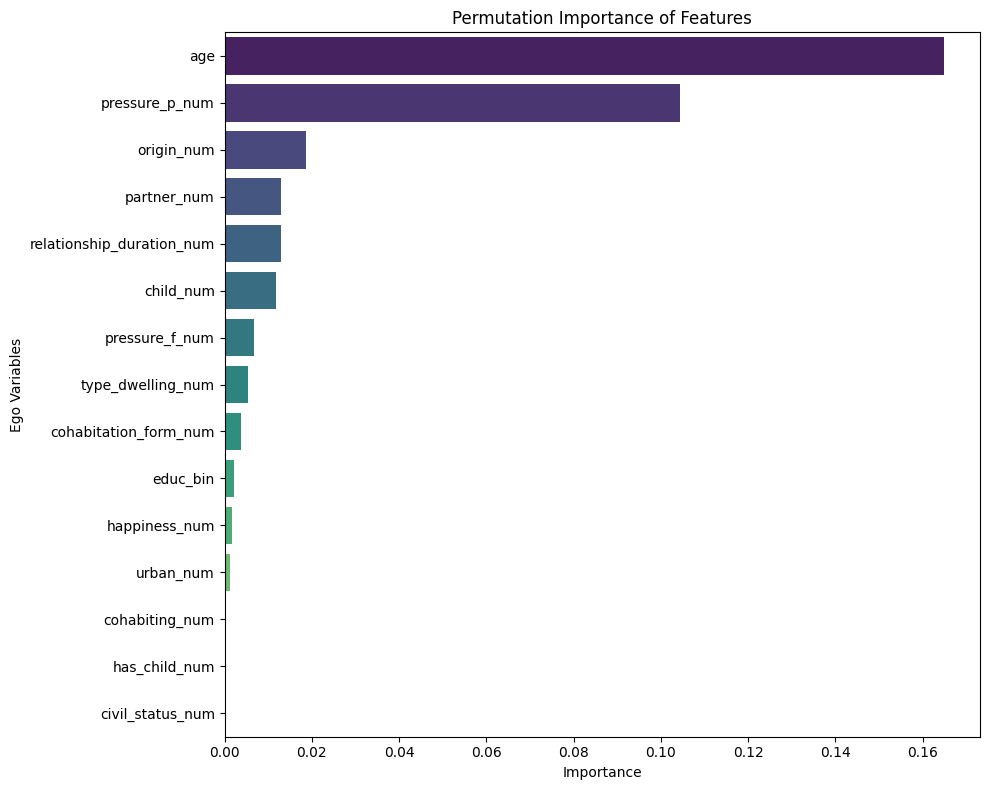

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the feature importance

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')

plt.title('Permutation Importance of Features')
plt.xlabel('Importance')
plt.ylabel('Ego Variables')
plt.tight_layout()

plt.show()


## 2.2. Network variables model

In [7]:
X_str = data[['mean_closeness',	'mean_f2f',	'mean_nonf2f',	'mean_closeness_kin',	'mean_closeness_friends',	'mean_closeness_has_kid',	'mean_closeness_want_kid',	'mean_closeness_wants_no_kid',
             'mean_closeness_help',	'mean_closeness_talk',	'mean_f2f_kin',	'mean_f2f_friends',	'mean_f2f_has_kid',	'mean_f2f_want_kid',	'mean_f2f_wants_no_kid',	'mean_f2f_help',	'mean_f2f_talk',	'mean_nonf2f_kin',
             'mean_nonf2f_friends',	'mean_nonf2f_has_kid',	'mean_nonf2f_want_kid',	'mean_nonf2f_wants_no_kid',	'mean_nonf2f_help',	'mean_nonf2f_talk',	'mean_closeness_kin_cor',	'mean_closeness_friends_cor',
             'mean_closeness_has_kid_cor',	'mean_closeness_want_kid_cor',	'mean_closeness_wants_no_kid_cor',	'mean_closeness_help_cor',	'mean_closeness_talk_cor',	'mean_f2f_kin_cor',	'mean_f2f_friends_cor',	'mean_f2f_has_kid_cor',
             'mean_f2f_want_kid_cor',	'mean_f2f_wants_no_kid_cor',	'mean_f2f_help_cor',	'mean_f2f_talk_cor',	'mean_nonf2f_kin_cor',	'mean_nonf2f_friends_cor',
             'mean_nonf2f_has_kid_cor',	'mean_nonf2f_want_kid_cor',	'mean_nonf2f_wants_no_kid_cor',	'mean_nonf2f_help_cor',	'mean_nonf2f_talk_cor',	'no_women',	'no_older',	'no_friends',	'no_kin',	'no_high_edu',	'no_has_child',
             'no_child_total',	'no_child_u5',	'no_child_less_happy',	'no_wants_child',	'no_wants_no_child',	'no_help',	'no_talk',	'density',	'density_kin',	'density_friends',	'density_children',	'density_wantschildren',	'density_childfree',
             'density_talk',	'density_help',	'comm_1or2',	'comm_3orhigher',	'modularity',	'comp_largest',	'diameter',	'between_centr',	'degree_centr',	'avg_betweenness',	'avg_closeness',	'avg_eigenv',	'cliques',	'components',	'density_kin_cor',
             'density_friends_cor',	'density_children_cor',	'density_wantschildren_cor',	'density_childfree_cor',	'density_talk_cor',	'density_help_cor' ]]
y = data['childwish_num']

# Creating a pipeline and Hyperparameter grid for tuning

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('gb', HistGradientBoostingClassifier())
])

param_grid = {
    'gb__max_iter': [100, 200, 300],
    'gb__max_depth': [None, 1, 5],
    'gb__min_samples_leaf': [1, 2, 4],
    'gb__learning_rate': [0.2, 0.1, 0.01]
}


grid_search_str = GridSearchCV(estimator=pipeline, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Train and evaluate the model with CV
grid_search_str.fit(X_str, y)

best_model_str = grid_search_str.best_estimator_

print(f"Best cross-validation accuracy: {grid_search.best_score_}")

# Cross-validation predictions
y_pred_str = cross_val_predict(best_model_str, X_str, y, cv=5)

# Print classification report
print(classification_report(y, y_pred_str))

# Print the best parameters
print("Best parameters found:", grid_search_str.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best cross-validation accuracy: 0.5563223140495868
              precision    recall  f1-score   support

           1       0.40      0.34      0.37        89
           2       0.33      0.24      0.28        98
           4       0.48      0.56      0.52       227
           5       0.49      0.50      0.49       190

    accuracy                           0.46       604
   macro avg       0.43      0.41      0.41       604
weighted avg       0.45      0.46      0.45       604

Best parameters found: {'gb__learning_rate': 0.1, 'gb__max_depth': 1, 'gb__max_iter': 300, 'gb__min_samples_leaf': 1}


In [12]:
# Calculate feature importance using permutation importance method

result = permutation_importance(best_model_str, X_str, y, n_repeats=10, random_state=42, n_jobs=-1)

importance_df = pd.DataFrame({
    'Feature': X_str.columns,
    'Importance': result.importances_mean,
    'Std Dev': result.importances_std
}).sort_values(by='Importance', ascending=False)

print("\nPermutation Importance Scores:")
print(importance_df)


Permutation Importance Scores:
                            Feature    Importance   Std Dev
51                   no_child_total  7.549669e-02  0.006378
54                   no_wants_child  4.023179e-02  0.010883
79              density_friends_cor  3.195364e-02  0.004744
65                     density_help  2.963576e-02  0.006474
11                 mean_f2f_friends  2.764901e-02  0.005186
12                 mean_f2f_has_kid  2.384106e-02  0.011735
52                      no_child_u5  2.350993e-02  0.005329
46                         no_older  2.251656e-02  0.007148
71                    between_centr  2.201987e-02  0.007976
0                    mean_closeness  2.135762e-02  0.007042
56                          no_help  2.119205e-02  0.003612
73                  avg_betweenness  2.069536e-02  0.005651
23                 mean_nonf2f_talk  1.953642e-02  0.004844
19              mean_nonf2f_has_kid  1.903974e-02  0.005889
6           mean_closeness_want_kid  1.870861e-02  0.012588
14      

## Permutation Importance Plots for Features

<ipython-input-14-c270bb2bfa6b>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=filtered_importance_df, palette='viridis')


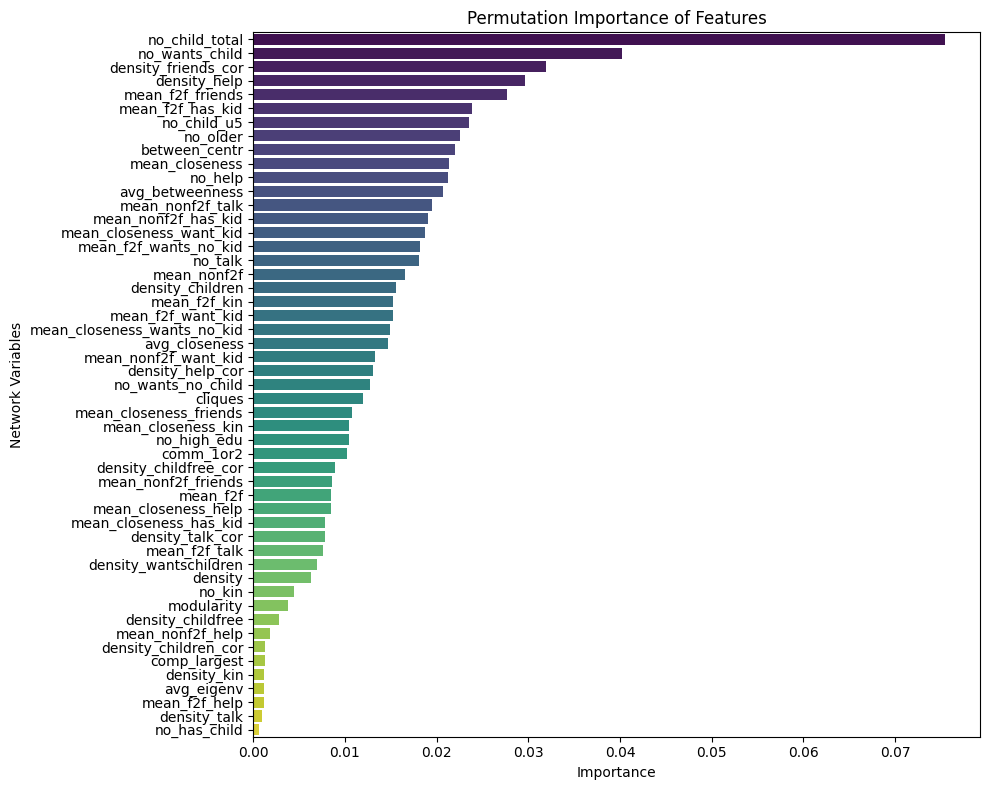

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filtering importance_df to include only features with importance > 0
filtered_importance_df = importance_df[importance_df['Importance'] > 0]

# Plotting the feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=filtered_importance_df, palette='viridis')

plt.title('Permutation Importance of Features')
plt.xlabel('Importance')
plt.ylabel('Network Variables')
plt.tight_layout()

plt.show()

<ipython-input-15-927269b7c4ca>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_10_importance_df, palette='viridis')


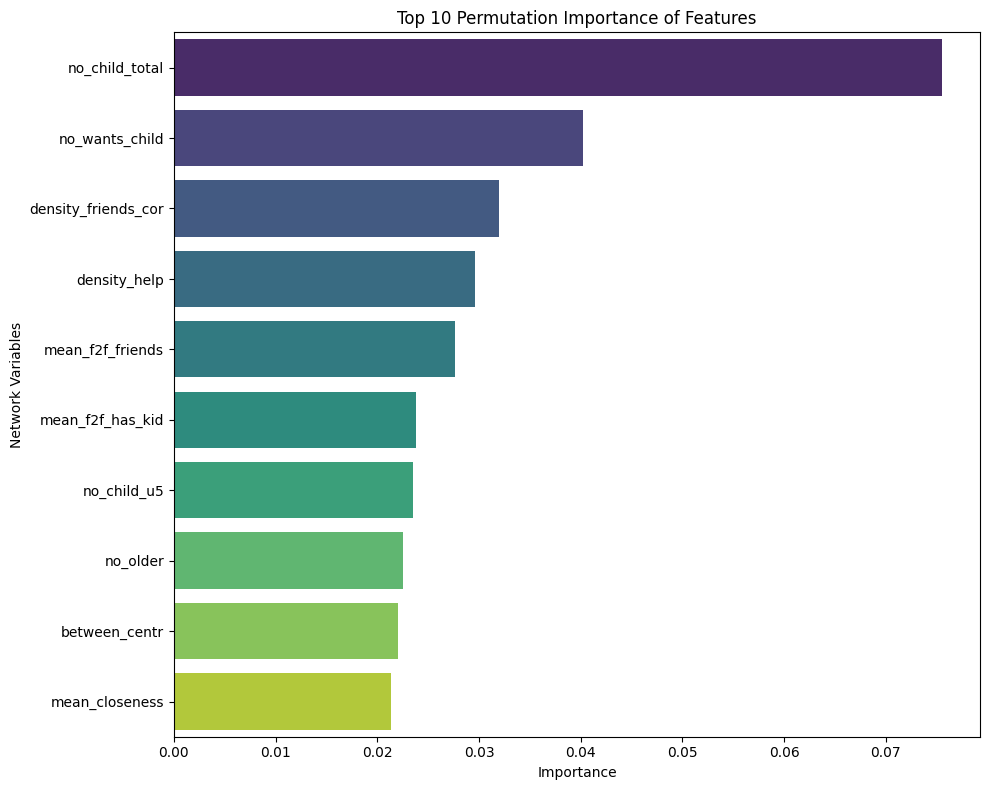

In [15]:
# Selecting the top 10 most important features
top_10_importance_df = filtered_importance_df.head(10)

# Plotting the feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_10_importance_df, palette='viridis')

plt.title('Top 10 Permutation Importance of Features')
plt.xlabel('Importance')
plt.ylabel('Network Variables')
plt.tight_layout()

plt.show()

## 2.3. Full model

In [8]:
X_full = data[['age', 'partner_num', 'has_child_num', 'educ_bin', 'child_num', 'relationship_duration_num','cohabiting_num','cohabitation_form_num', 'happiness_num', 'pressure_f_num', 'pressure_p_num', 'civil_status_num', 'urban_num', 'type_dwelling_num','origin_num',
              'mean_closeness',	'mean_f2f',	'mean_nonf2f',	'mean_closeness_kin',	'mean_closeness_friends',	'mean_closeness_has_kid',	'mean_closeness_want_kid',	'mean_closeness_wants_no_kid',
             'mean_closeness_help',	'mean_closeness_talk',	'mean_f2f_kin',	'mean_f2f_friends',	'mean_f2f_has_kid',	'mean_f2f_want_kid',	'mean_f2f_wants_no_kid',	'mean_f2f_help',	'mean_f2f_talk',	'mean_nonf2f_kin',
             'mean_nonf2f_friends',	'mean_nonf2f_has_kid',	'mean_nonf2f_want_kid',	'mean_nonf2f_wants_no_kid',	'mean_nonf2f_help',	'mean_nonf2f_talk',	'mean_closeness_kin_cor',	'mean_closeness_friends_cor',
             'mean_closeness_has_kid_cor',	'mean_closeness_want_kid_cor',	'mean_closeness_wants_no_kid_cor',	'mean_closeness_help_cor',	'mean_closeness_talk_cor',	'mean_f2f_kin_cor',	'mean_f2f_friends_cor',	'mean_f2f_has_kid_cor',
             'mean_f2f_want_kid_cor',	'mean_f2f_wants_no_kid_cor',	'mean_f2f_help_cor',	'mean_f2f_talk_cor',	'mean_nonf2f_kin_cor',	'mean_nonf2f_friends_cor',
             'mean_nonf2f_has_kid_cor',	'mean_nonf2f_want_kid_cor',	'mean_nonf2f_wants_no_kid_cor',	'mean_nonf2f_help_cor',	'mean_nonf2f_talk_cor',	'no_women',	'no_older',	'no_friends',	'no_kin',	'no_high_edu',	'no_has_child',
             'no_child_total',	'no_child_u5',	'no_child_less_happy',	'no_wants_child',	'no_wants_no_child',	'no_help',	'no_talk',	'density',	'density_kin',	'density_friends',	'density_children',	'density_wantschildren',	'density_childfree',
             'density_talk',	'density_help',	'comm_1or2',	'comm_3orhigher',	'modularity',	'comp_largest',	'diameter',	'between_centr',	'degree_centr',	'avg_betweenness',	'avg_closeness',	'avg_eigenv',	'cliques',	'components',	'density_kin_cor',
             'density_friends_cor',	'density_children_cor',	'density_wantschildren_cor',	'density_childfree_cor',	'density_talk_cor',	'density_help_cor' ]]

y = data['childwish_num']

# Creating a pipeline and Hyperparameter grid for tuning

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('gb', HistGradientBoostingClassifier())
])

param_grid = {
    'gb__max_iter': [30, 50, 60],
    'gb__max_depth': [10, 15, 20],
    'gb__min_samples_leaf': [1, 2, 4],
    'gb__learning_rate': [0.1, 0.15, 0.2]
}


grid_search_full = GridSearchCV(estimator=pipeline, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Train and evaluate the model with CV
grid_search_full.fit(X_full, y)

best_model_full = grid_search_full.best_estimator_

print(f"Best cross-validation accuracy: {grid_search_full.best_score_}")

# Cross-validation predictions
y_pred_full = cross_val_predict(best_model_full, X_full, y, cv=5)

# Print classification report
print(classification_report(y, y_pred_full))

# Print the best parameters
print("Best parameters found:", grid_search_full.best_params_)

# Calculate feature importance using permutation importance method

result = permutation_importance(best_model_full, X_full, y, n_repeats=10, random_state=42, n_jobs=-1)

importance_df = pd.DataFrame({
    'Feature': X_full.columns,
    'Importance': result.importances_mean,
    'Std Dev': result.importances_std
}).sort_values(by='Importance', ascending=False)

print("\nPermutation Importance Scores:")
print(importance_df)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best cross-validation accuracy: 0.5249035812672176
              precision    recall  f1-score   support

           1       0.58      0.58      0.58        89
           2       0.40      0.27      0.32        98
           4       0.53      0.62      0.57       227
           5       0.54      0.52      0.53       190

    accuracy                           0.52       604
   macro avg       0.51      0.50      0.50       604
weighted avg       0.52      0.52      0.52       604

Best parameters found: {'gb__learning_rate': 0.1, 'gb__max_depth': 15, 'gb__max_iter': 50, 'gb__min_samples_leaf': 4}

Permutation Importance Scores:
                            Feature  Importance   Std Dev
0                               age    0.179801  0.011735
10                   pressure_p_num    0.065397  0.008985
69                   no_wants_child    0.000828  0.001111
60                         no_women    0.000828  0.000828
64          

<ipython-input-17-a7cb560d054a>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=filtered_importance_df, palette='viridis')


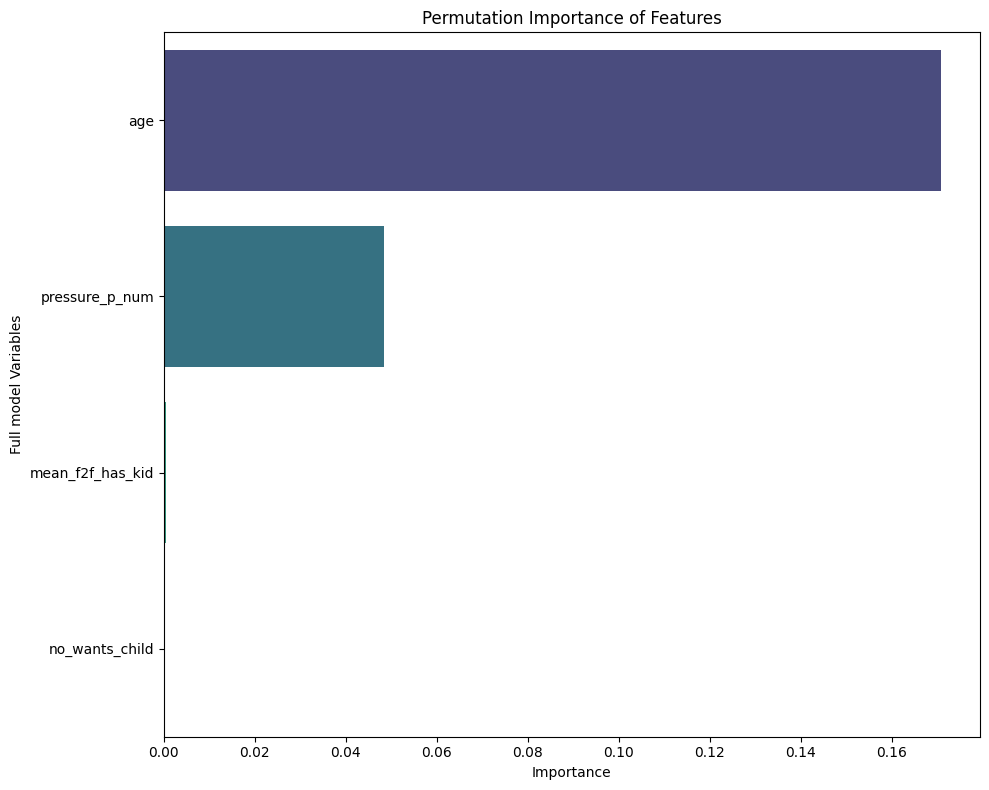

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filtering importance_df to include only features with importance > 0
filtered_importance_df = importance_df[importance_df['Importance'] > 0]

# Plotting the feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=filtered_importance_df, palette='viridis')

plt.title('Permutation Importance of Features')
plt.xlabel('Importance')
plt.ylabel('Full model Variables')
plt.tight_layout()

plt.show()

## Partial Dependence Plots



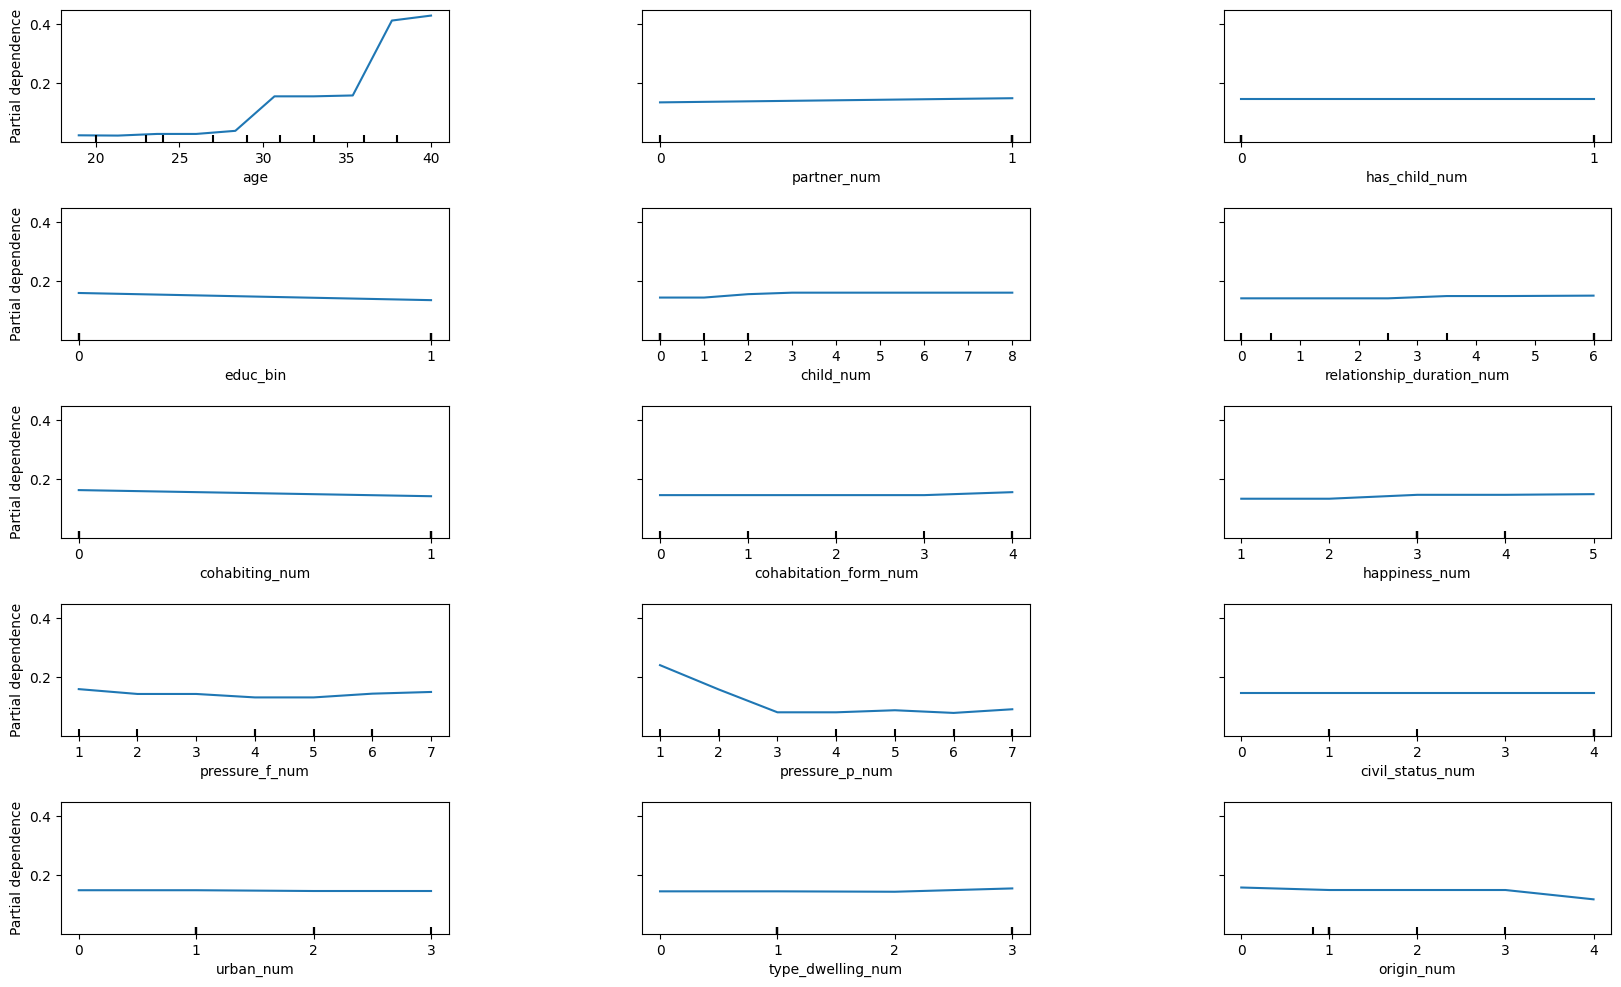

In [9]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

X = data[['age', 'partner_num', 'has_child_num', 'educ_bin', 'child_num', 'relationship_duration_num','cohabiting_num',
 'cohabitation_form_num', 'happiness_num', 'pressure_f_num', 'pressure_p_num', 'civil_status_num', 'urban_num', 'type_dwelling_num','origin_num' ]]


features = ['age', 'partner_num', 'has_child_num', 'educ_bin', 'child_num', 'relationship_duration_num','cohabiting_num',
 'cohabitation_form_num', 'happiness_num', 'pressure_f_num', 'pressure_p_num', 'civil_status_num', 'urban_num', 'type_dwelling_num','origin_num']


# Partial Dependence Plot for class 1( Absolutely not)&Ego model

fig, ax = plt.subplots(figsize=(20, 12))

pdp_disp = PartialDependenceDisplay.from_estimator(
    best_model, X, features, target=1, grid_resolution=10, ax=ax)

#intervals

for i, ax in enumerate(pdp_disp.axes_.ravel()):
    feature = features[i]
    if feature != 'age':
        ax.set_xticks(range(int(X[feature].min()), int(X[feature].max()) + 1))

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()


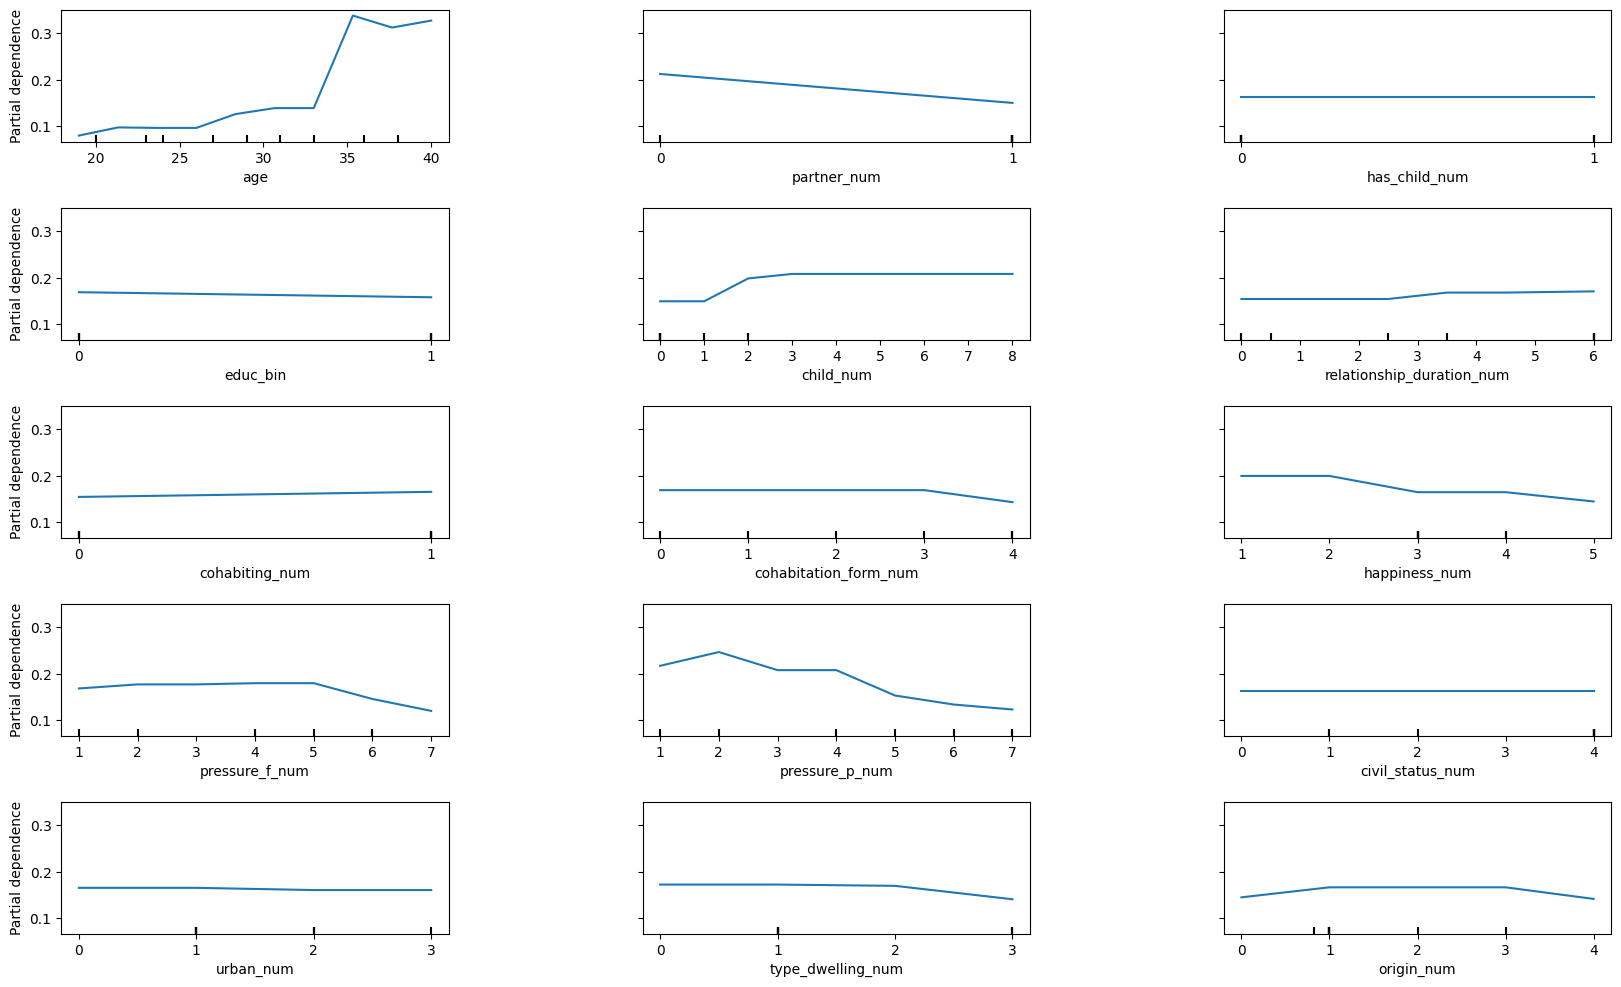

In [11]:
# Partial Dependence Plot for class 2(probably not) & Ego model

fig, ax = plt.subplots(figsize=(20, 12))

pdp_disp = PartialDependenceDisplay.from_estimator(
    best_model, X, features, target=2, grid_resolution=10, ax=ax)

#intervals

for i, ax in enumerate(pdp_disp.axes_.ravel()):
    feature = features[i]
    if feature != 'age':
        ax.set_xticks(range(int(X[feature].min()), int(X[feature].max()) + 1))

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

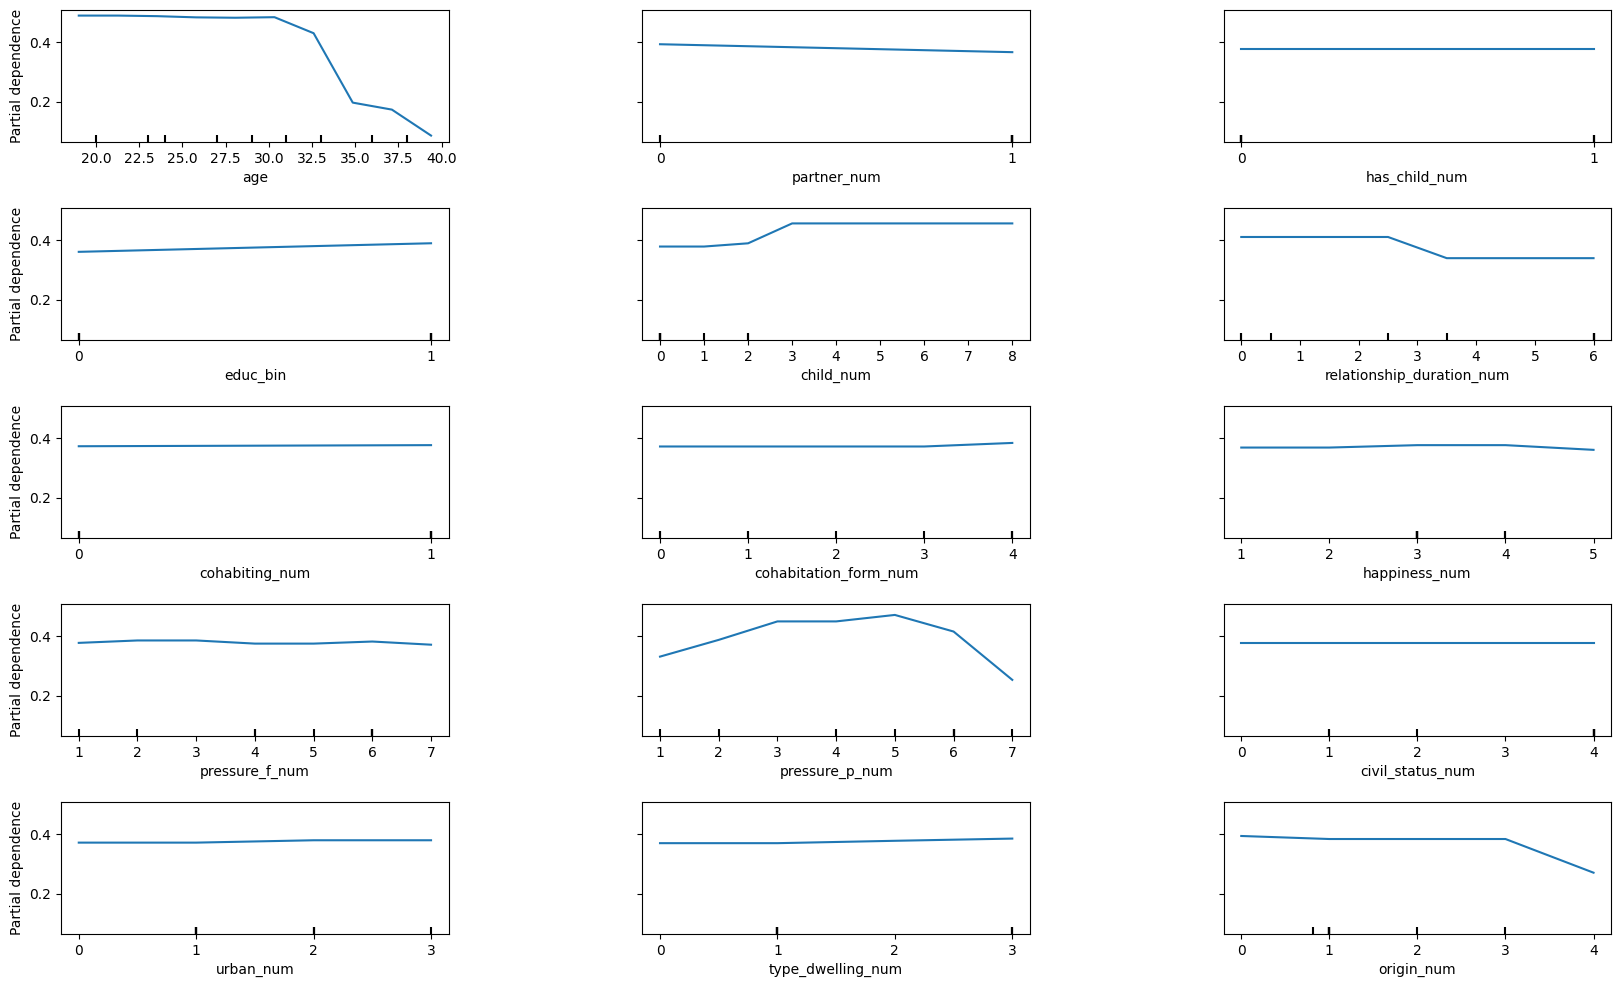

In [ ]:
# Partial Dependence Plot for class 4( Probably so) & Ego model

fig, ax = plt.subplots(figsize=(20, 12))

pdp_disp = PartialDependenceDisplay.from_estimator(
    best_model, X, features, target=4, grid_resolution=10, ax=ax)

#intervals

for i, ax in enumerate(pdp_disp.axes_.ravel()):
    feature = features[i]
    if feature != 'age':
        ax.set_xticks(range(int(X[feature].min()), int(X[feature].max()) + 1))

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

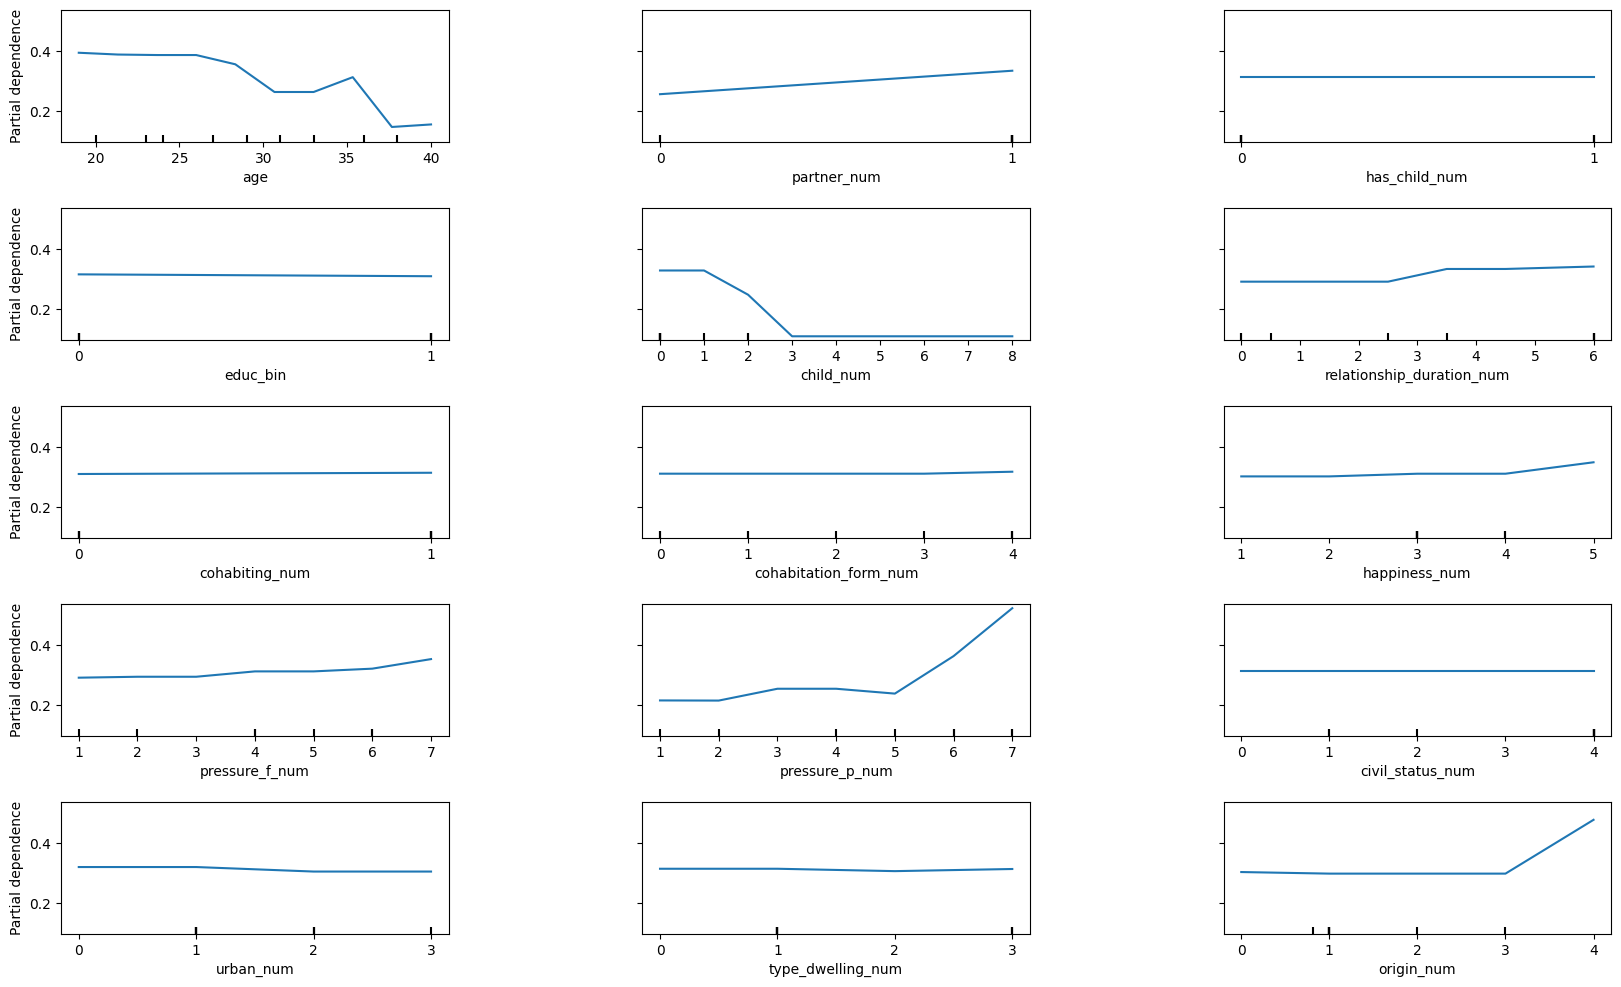

In [10]:
# Partial Dependence Plot for class 5( Absolutely so) & Ego model

fig, ax = plt.subplots(figsize=(20, 12))

pdp_disp = PartialDependenceDisplay.from_estimator(
    best_model, X, features, target=5, grid_resolution=10, ax=ax)

#intervals

for i, ax in enumerate(pdp_disp.axes_.ravel()):
    feature = features[i]
    if feature != 'age':
        ax.set_xticks(range(int(X[feature].min()), int(X[feature].max()) + 1))

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

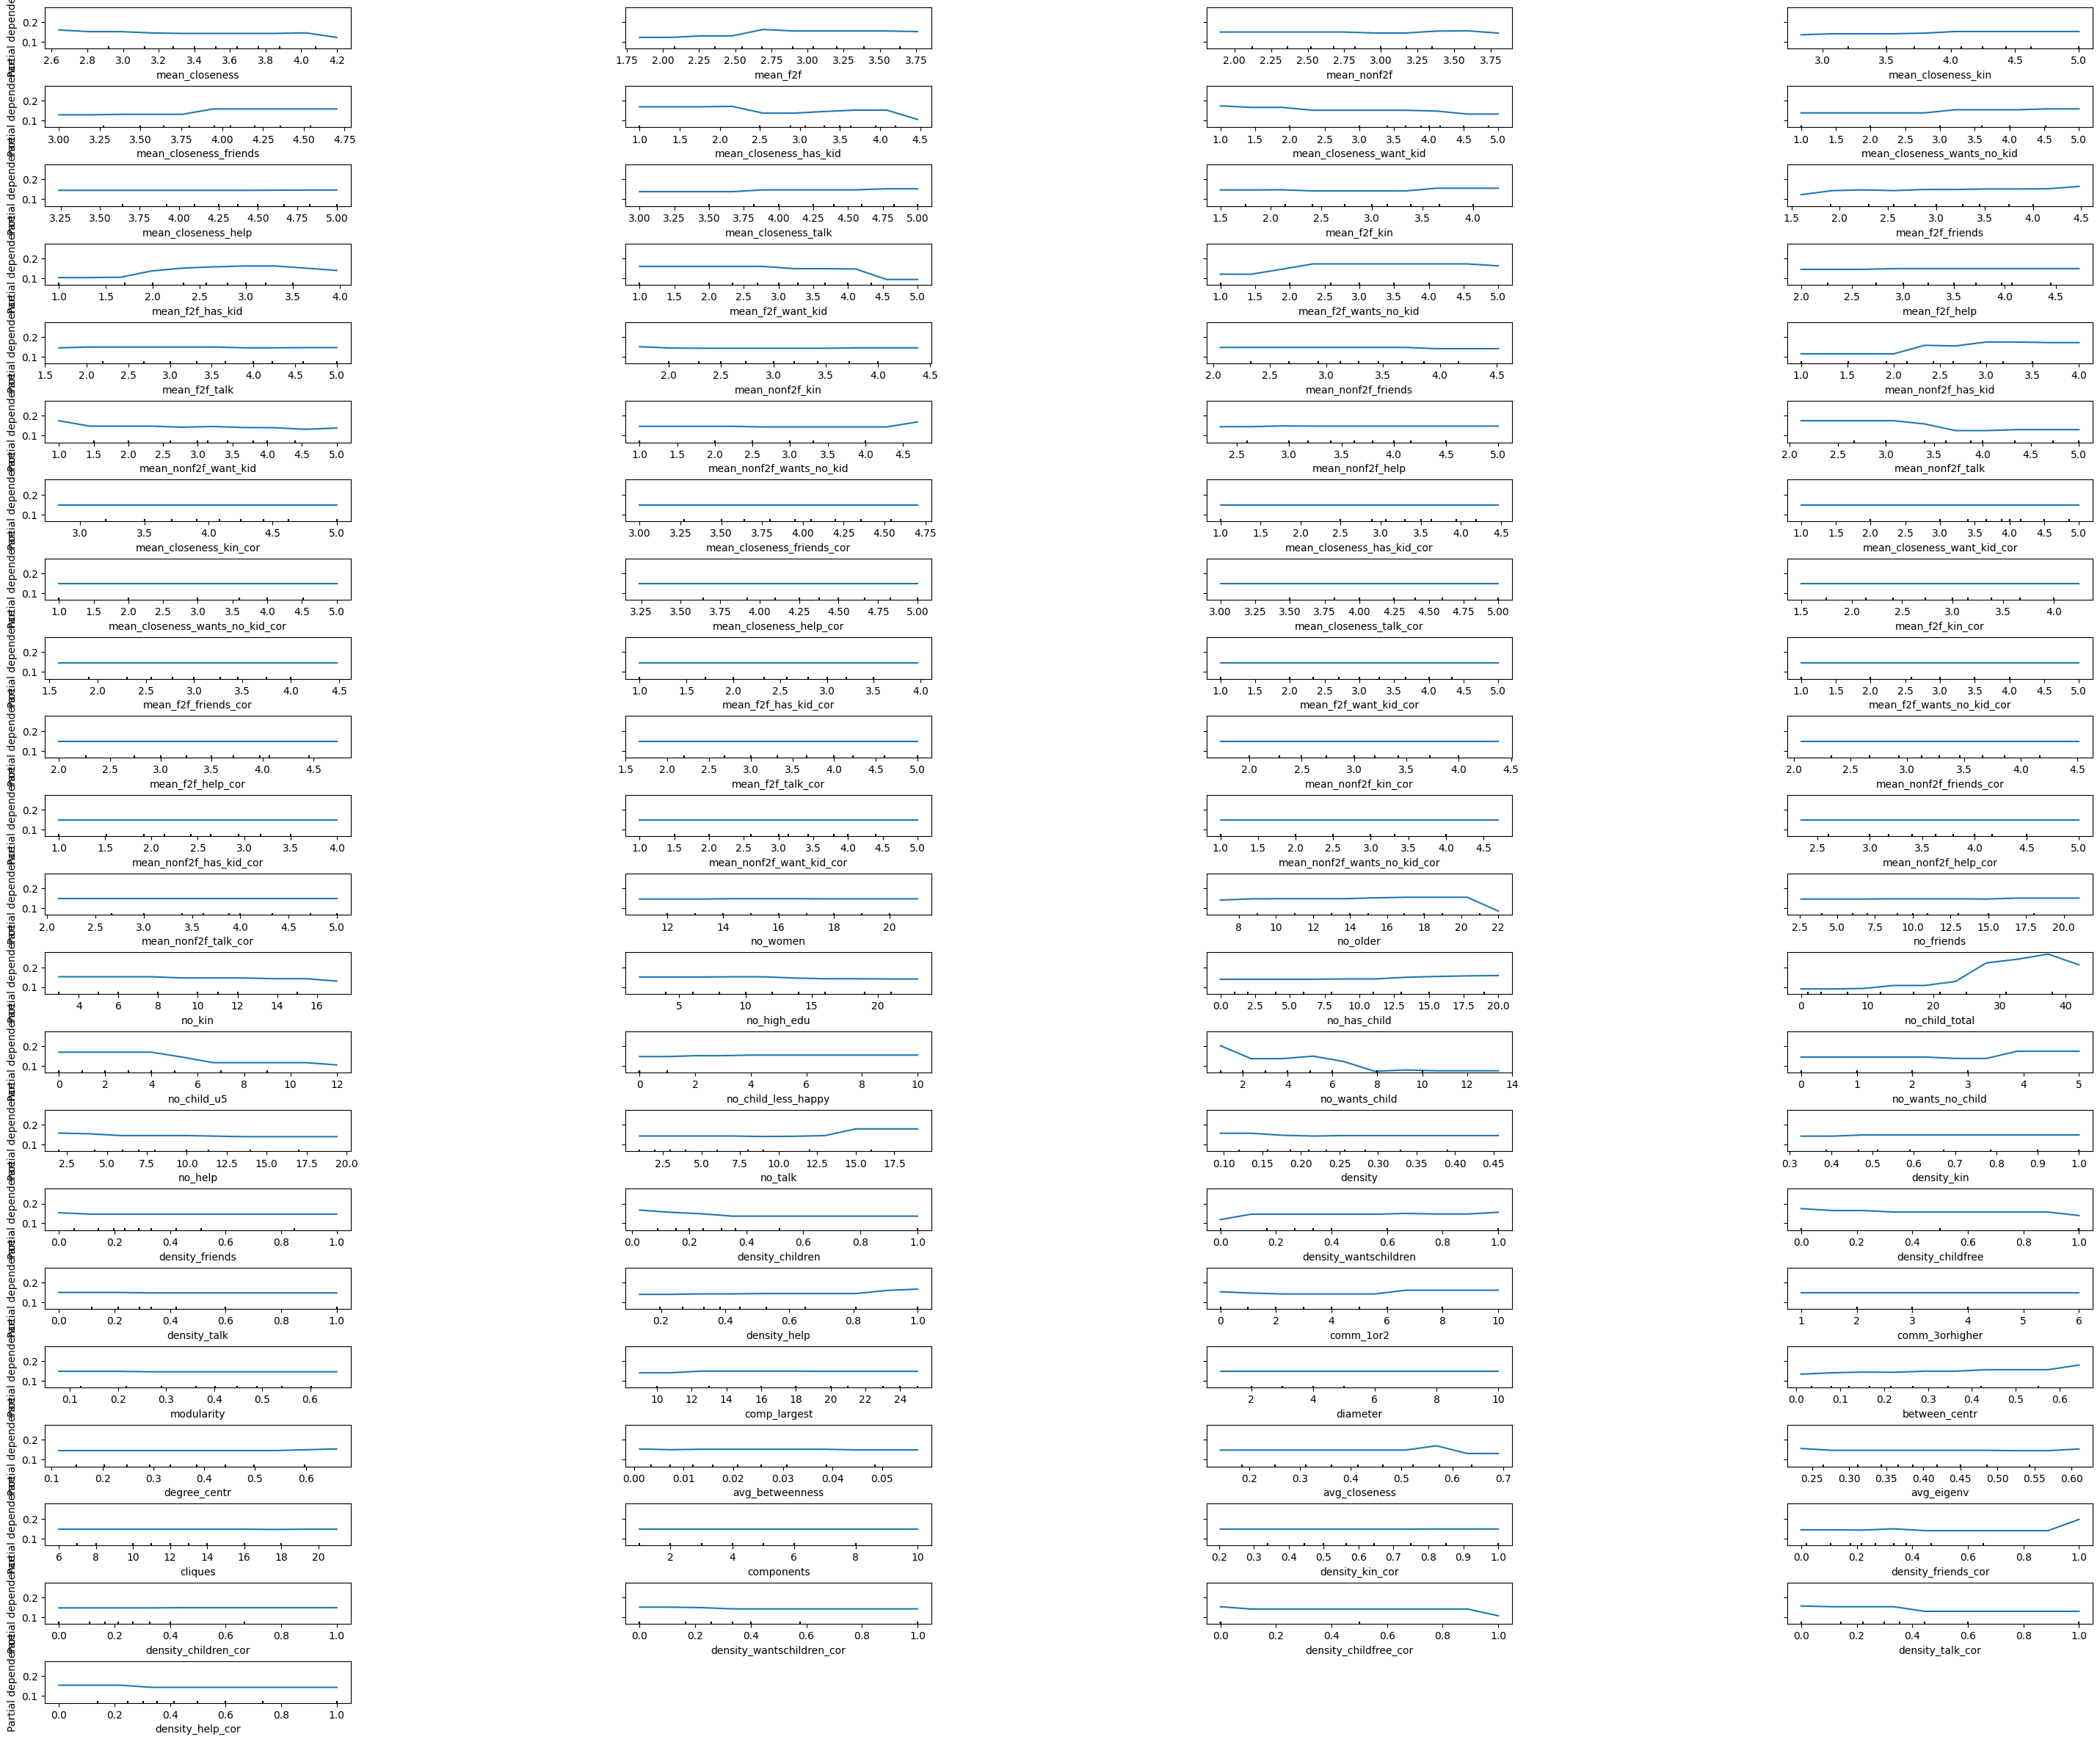

In [12]:

X_str = data[['mean_closeness', 'mean_f2f', 'mean_nonf2f', 'mean_closeness_kin', 'mean_closeness_friends',
              'mean_closeness_has_kid', 'mean_closeness_want_kid', 'mean_closeness_wants_no_kid',
              'mean_closeness_help', 'mean_closeness_talk', 'mean_f2f_kin', 'mean_f2f_friends',
              'mean_f2f_has_kid', 'mean_f2f_want_kid', 'mean_f2f_wants_no_kid', 'mean_f2f_help',
              'mean_f2f_talk', 'mean_nonf2f_kin', 'mean_nonf2f_friends', 'mean_nonf2f_has_kid',
              'mean_nonf2f_want_kid', 'mean_nonf2f_wants_no_kid', 'mean_nonf2f_help', 'mean_nonf2f_talk',
              'mean_closeness_kin_cor', 'mean_closeness_friends_cor', 'mean_closeness_has_kid_cor',
              'mean_closeness_want_kid_cor', 'mean_closeness_wants_no_kid_cor', 'mean_closeness_help_cor',
              'mean_closeness_talk_cor', 'mean_f2f_kin_cor', 'mean_f2f_friends_cor', 'mean_f2f_has_kid_cor',
              'mean_f2f_want_kid_cor', 'mean_f2f_wants_no_kid_cor', 'mean_f2f_help_cor', 'mean_f2f_talk_cor',
              'mean_nonf2f_kin_cor', 'mean_nonf2f_friends_cor', 'mean_nonf2f_has_kid_cor',
              'mean_nonf2f_want_kid_cor', 'mean_nonf2f_wants_no_kid_cor', 'mean_nonf2f_help_cor',
              'mean_nonf2f_talk_cor', 'no_women', 'no_older', 'no_friends', 'no_kin', 'no_high_edu',
              'no_has_child', 'no_child_total', 'no_child_u5', 'no_child_less_happy', 'no_wants_child',
              'no_wants_no_child', 'no_help', 'no_talk', 'density', 'density_kin', 'density_friends',
              'density_children', 'density_wantschildren', 'density_childfree', 'density_talk',
              'density_help', 'comm_1or2', 'comm_3orhigher', 'modularity', 'comp_largest', 'diameter',
              'between_centr', 'degree_centr', 'avg_betweenness', 'avg_closeness', 'avg_eigenv', 'cliques',
              'components', 'density_kin_cor', 'density_friends_cor', 'density_children_cor',
              'density_wantschildren_cor', 'density_childfree_cor', 'density_talk_cor', 'density_help_cor']]

features_str = X_str.columns.tolist()

# Partial Dependence Plot for class 1( Absolutely not) & Network model
fig, ax = plt.subplots(figsize=(36, 30))

pdp_disp = PartialDependenceDisplay.from_estimator(
    best_model_str, X_str, features_str, target=1, grid_resolution=10, n_cols=4, ax=ax)

plt.subplots_adjust(wspace=0.9, hspace=0.9)
plt.show()



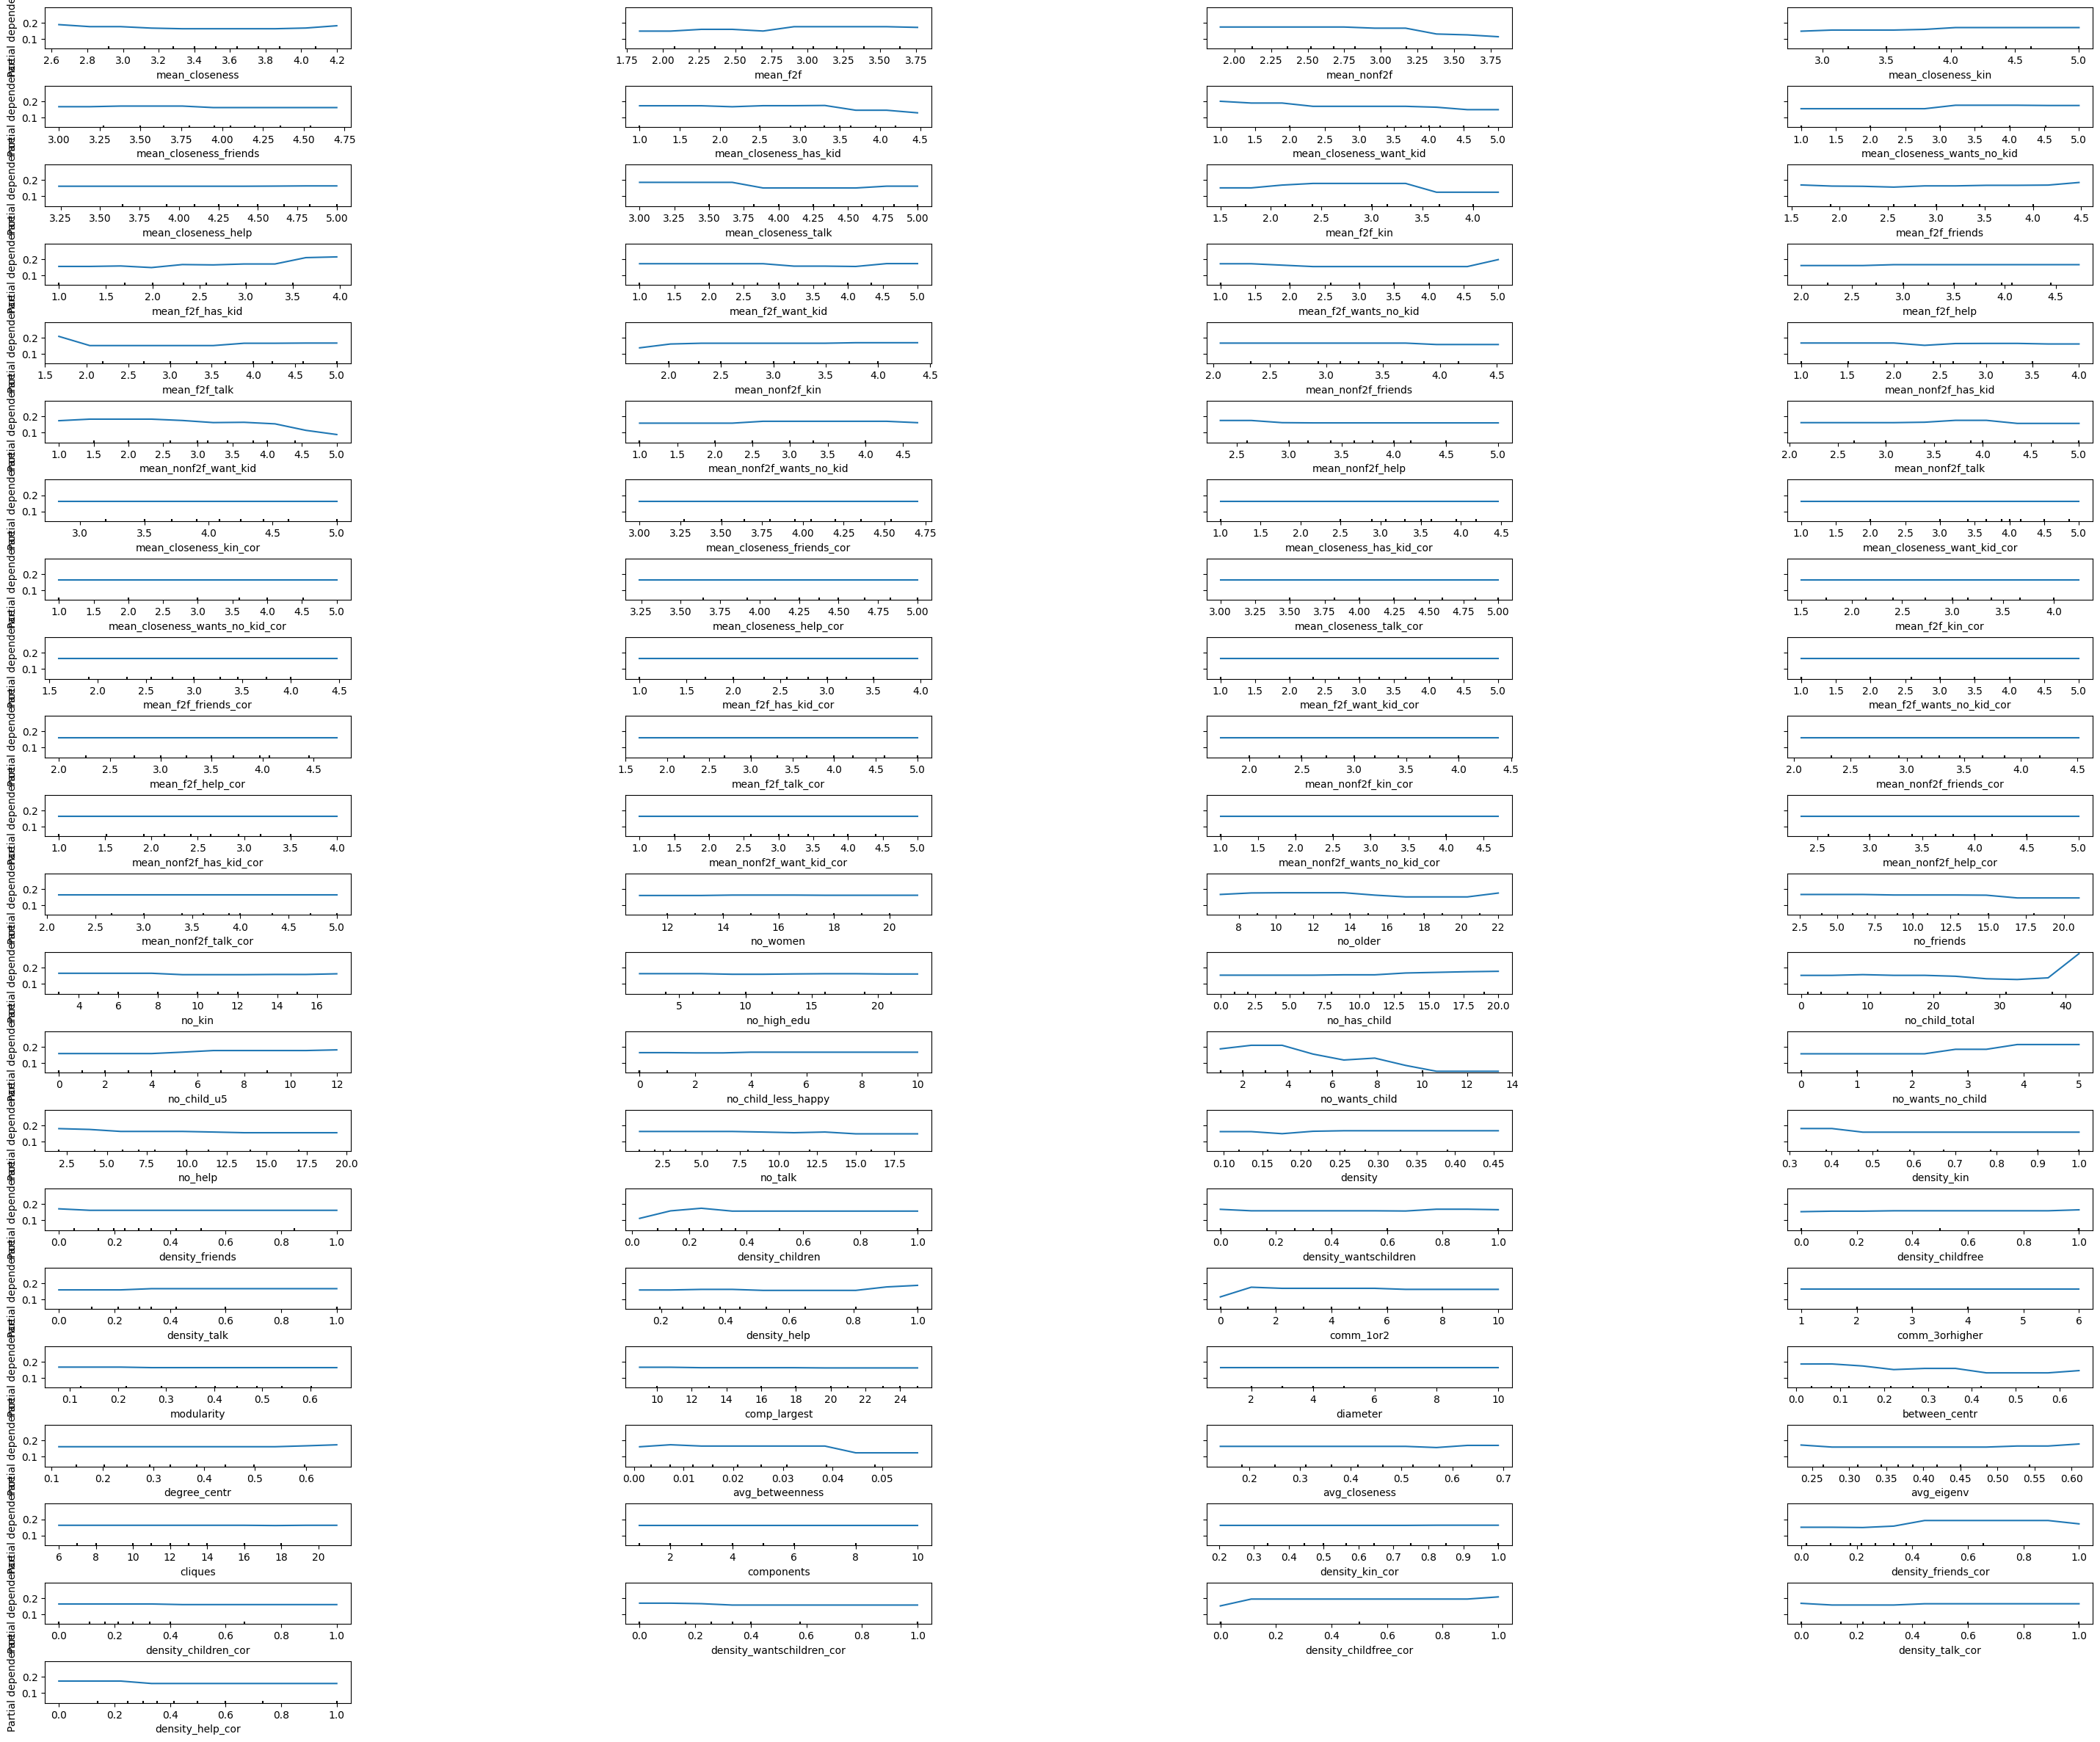

In [13]:
#Partial Dependence Plot for class 2(Probably not) & Network model
fig, ax = plt.subplots(figsize=(36, 30))

pdp_disp = PartialDependenceDisplay.from_estimator(
    best_model_str, X_str, features_str, target=2, grid_resolution=10, n_cols=4, ax=ax)

plt.subplots_adjust(wspace=0.9, hspace=0.9)
plt.show()

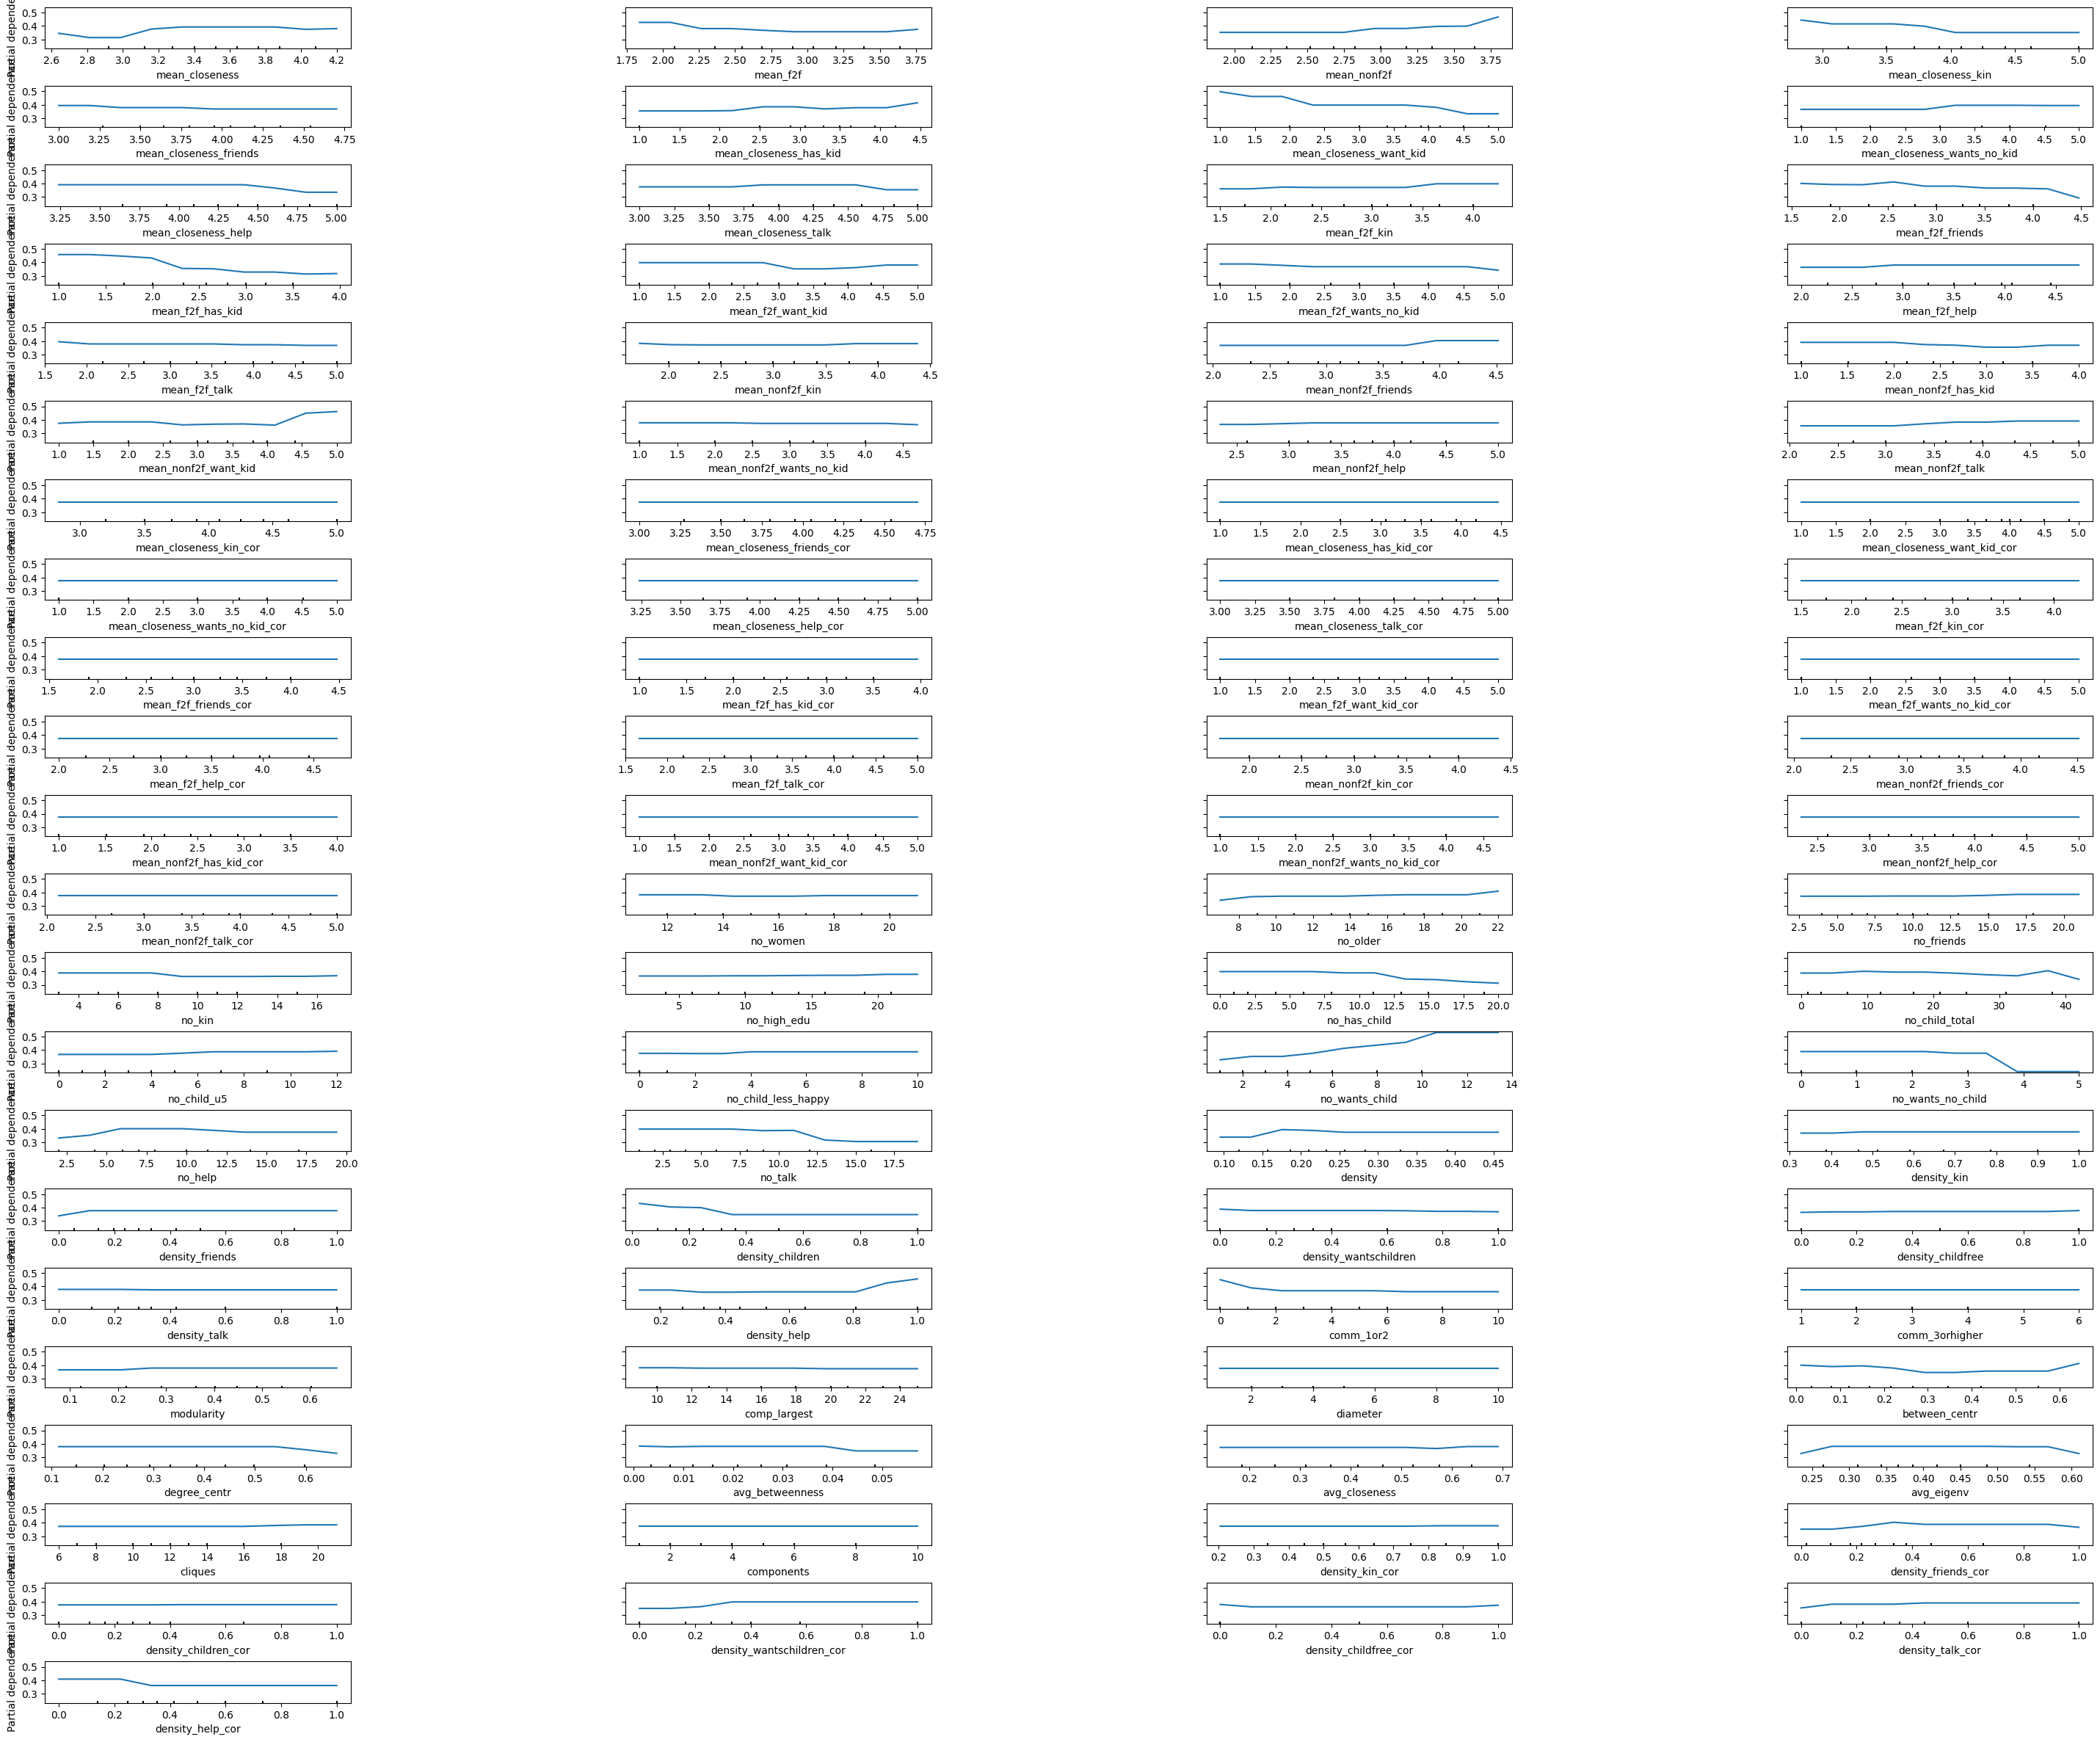

In [14]:
#Partial Dependence Plot for class 4 (Probably so) & Network model
fig, ax = plt.subplots(figsize=(36, 30))

pdp_disp = PartialDependenceDisplay.from_estimator(
    best_model_str, X_str, features_str, target=4, grid_resolution=10, n_cols=4, ax=ax)

plt.subplots_adjust(wspace=0.9, hspace=0.9)
plt.show()

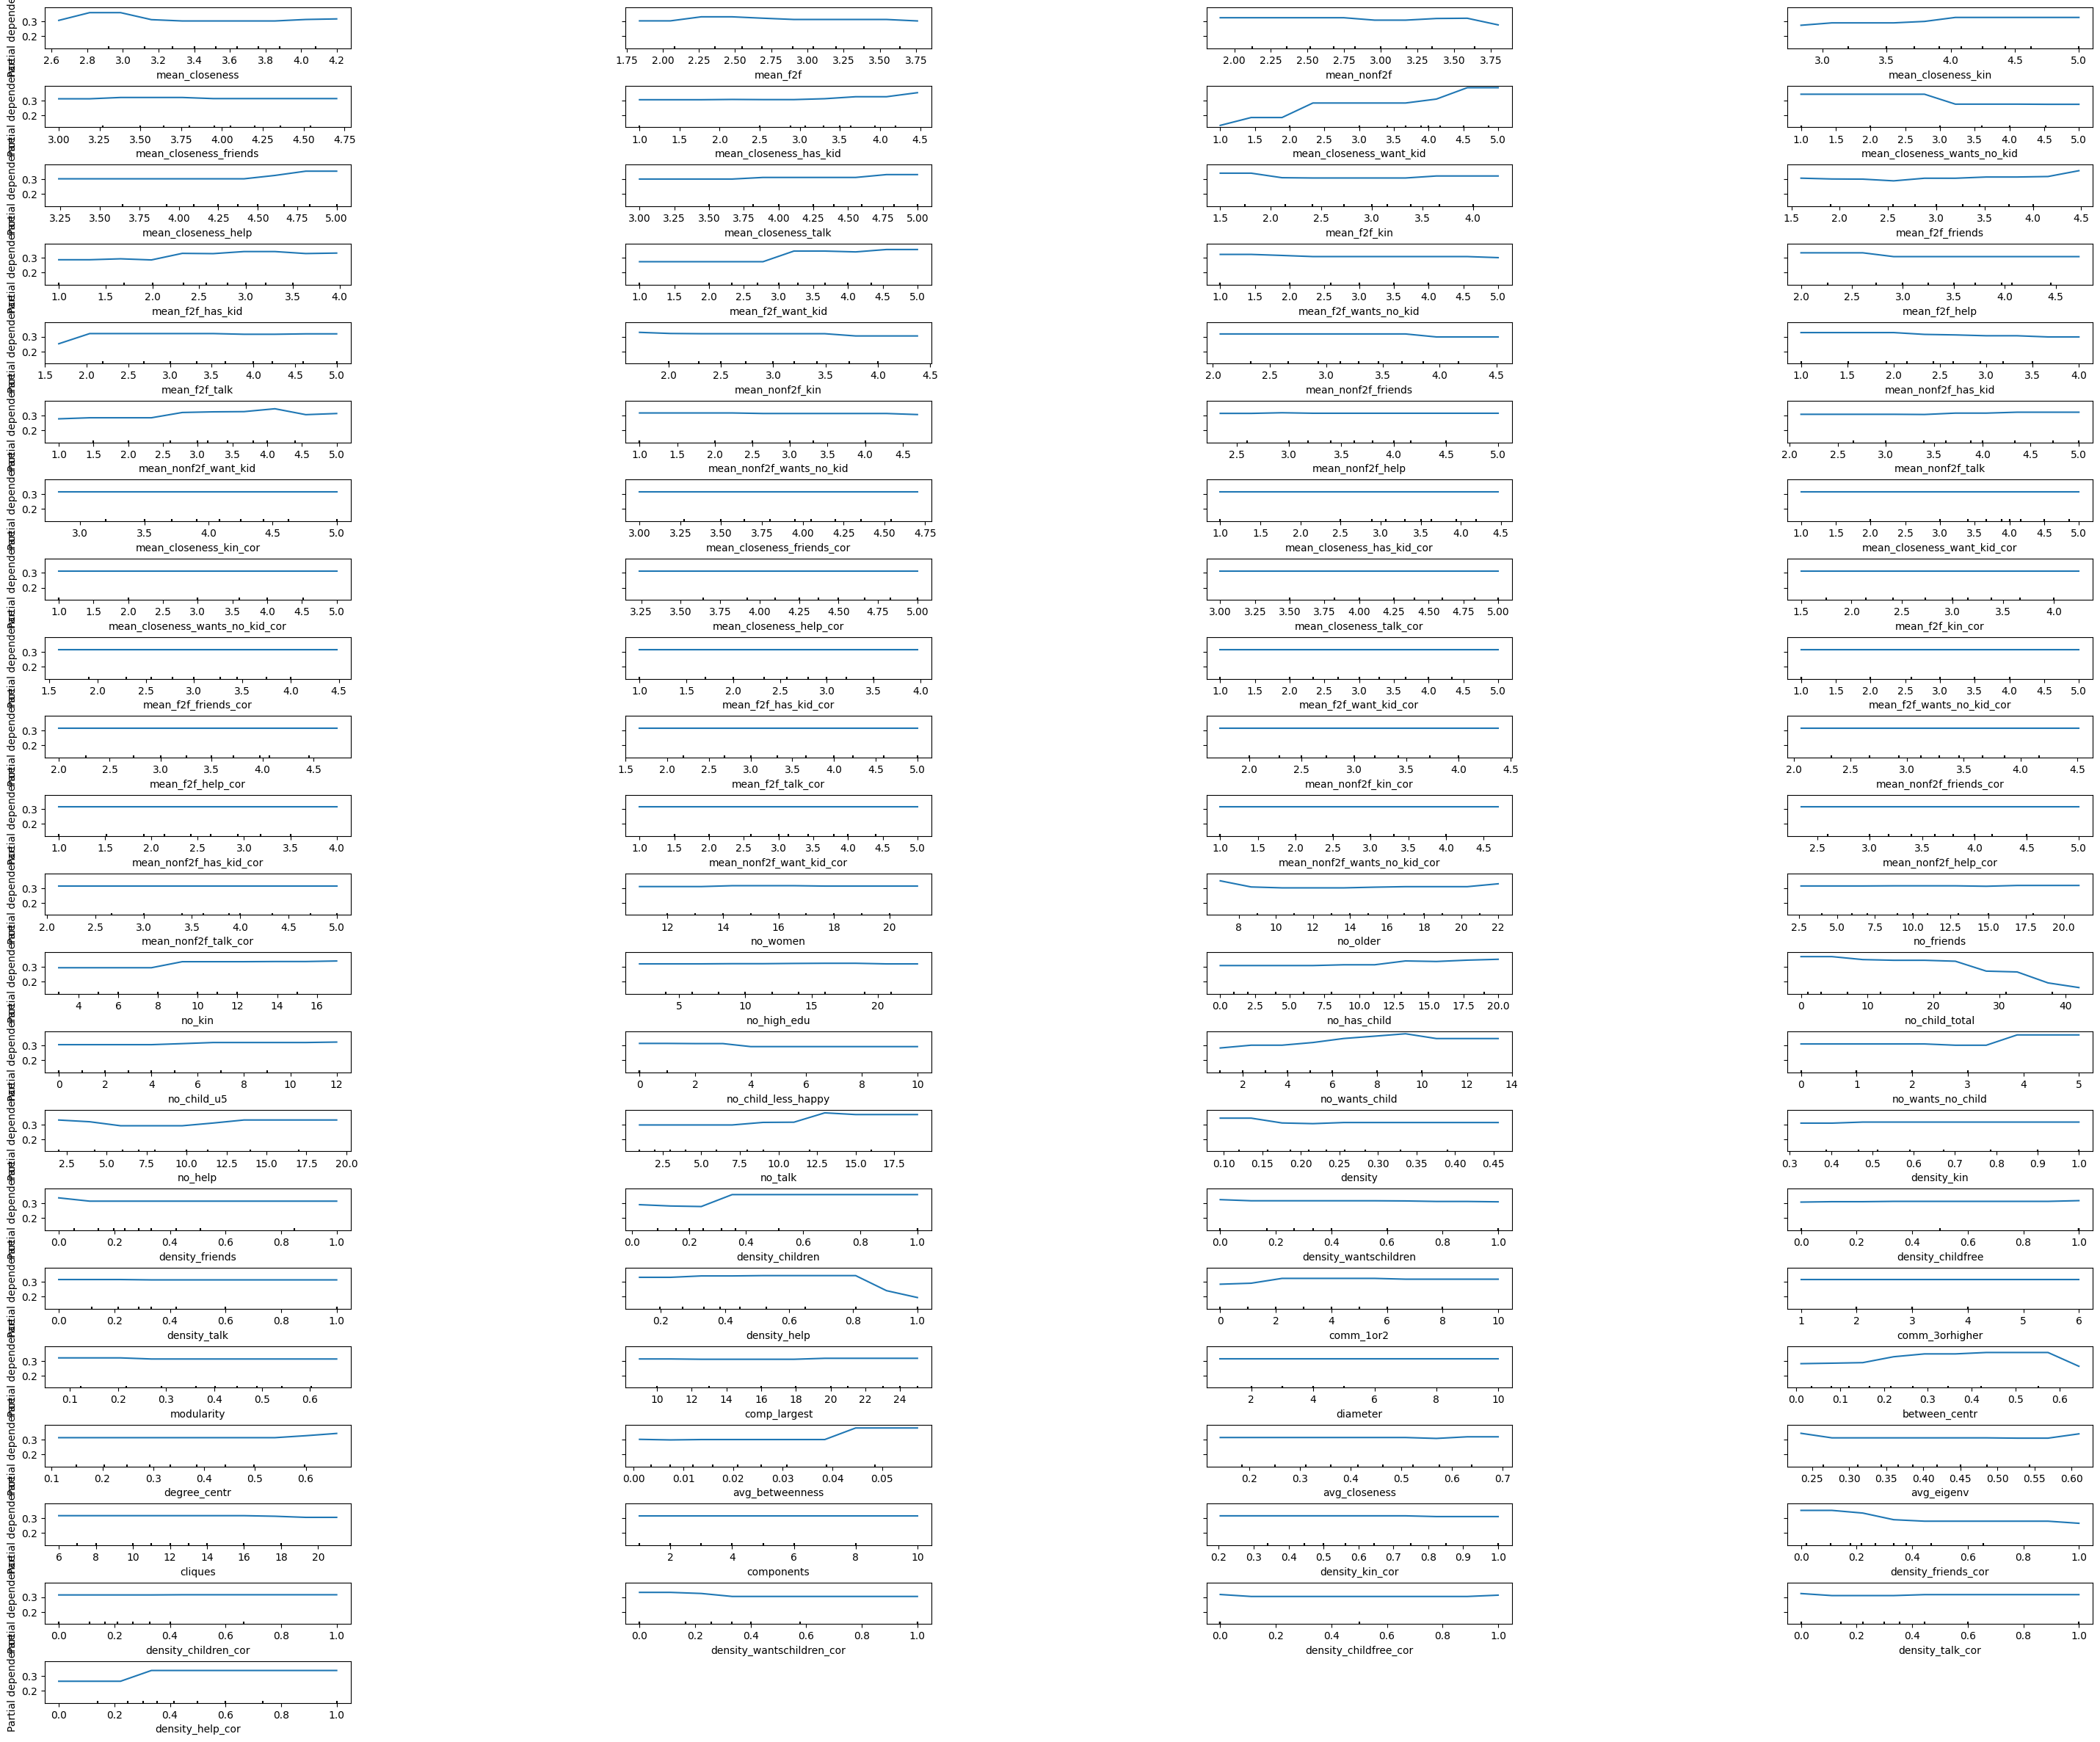

In [15]:
#Partial Dependence Plot for class 5 (Absolutely not) & Network model
fig, ax = plt.subplots(figsize=(36, 30))

pdp_disp = PartialDependenceDisplay.from_estimator(
    best_model_str, X_str, features_str, target=5, grid_resolution=10, n_cols=4, ax=ax)

plt.subplots_adjust(wspace=0.9, hspace=0.9)
plt.show()